In [1]:
# import libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy import stats
from matplotlib.ticker import MaxNLocator
from collections import Counter


In [2]:
# load data
df = pd.read_csv("../data/2_dataset.csv", low_memory=False)
# df that we will use for EDA
eda_df = df.copy()

# Exploratory Data Analysis (EDA)

## Preface 

Previous treatments :

* 1_dataset_engineering.ipynb

The explanaition of all the variables of the dataset is done in the notebook : 1_dataset_engineering.ipynb

## Objective

Our goal here is to analyze the existing variables in relation to our target (delay in minutes of a bus) to determine what treatments we will do to our data to reveal the patterns that we found.

## Table of contents

- [Dataset global overview](#dataset-global-overview)

  - [Dataset format](#dataset-format)
  - [Missing and duplicated data](#missing-and-duplicated-data)

    - [Removing rows with missing weather data](#removing-rows-with-missing-weather-data)
    - [Dropping missing ROUTE values](#dropping-missing-route-values)
    - [Dropping data duplicates](#dropping-data-duplicates)
    - [Special case - Handling HUMIDEX and WINDCHILL](#special-case---handling-humidex-and-windchill)
    - [Special case - Handling the missing WEATHER_ENG_DESC values](#special-case---handling-the-missing-weather_eng_desc-values)

- [Univariate analysis](#univariate-analysis)

  - [Target variable: DELAY](#target-variable-delay)
  - [Temporal variables](#temporal-variables)

    - [LOCAL_TIME](#local_time)
    - [WEEK_DAY](#week_day)
    - [LOCAL_MONTH](#local_month)
    - [LOCAL_DAY](#local_day)

  - [Categorical variables](#categorical-variables)

    - [ROUTE](#route)
    - [INCIDENT](#incident)
    - [WEATHER_ENG_DESC](#weather_eng_desc)

  - [Numerical variable](#numerical-variables)

    - [TEMP](#temp)
    - [DEW_POINT_TEMP](#dew_point_temp)
    - [HUMIDEX](#humidex)
    - [PRECIP_AMOUNT](#precip_amount)
    - [RELATIVE_HUMIDITY](#relative_humidity)
    - [STATION_PRESSURE](#station_pressure)
    - [VISIBILITY](#visibility)
    - [WIND_DIRECTION](#wind_direction)
    - [WIND_SPEED](#wind_speed)

- [Bivariate analysis](#bivariate-analysis)

  - [DELAY / ROUTE](#delay--route)
  - [DELAY / INCIDENT](#delay--incident)
  - [DELAY / WEATHER_ENG_DESC_LIST](#delay--weather_eng_desc_list)
  - [DELAY / WEEK_DAY](#delay--week_day)
  - [DELAY / LOCAL_MONTH](#delay--local_month)
  - [DELAY / TEMP](#delay--temp)
  - [DELAY / PRECIPITATIONS](#delay--precipitations)
  - [DELAY / VISIBILITY](#delay--visibility)
  - [DELAY / WIND_SPEED](#delay--wind_speed)

- [Conclusions](#conclusions)

## Dataset global overview

Before getting into the univariate analysis of each one of our dataset's variables, we will first observe the global overview of the dataset.


### Dataset format

In [3]:
df.shape

(50913, 18)

We have 50913 entries for 17 variables. As mentionned previously the details for each variable can be found in `1_dataset_engineering.ipynb`.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50913 entries, 0 to 50912
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ROUTE              50385 non-null  object 
 1   LOCAL_TIME         50913 non-null  object 
 2   WEEK_DAY           50913 non-null  object 
 3   INCIDENT           50913 non-null  object 
 4   DELAY              50913 non-null  int64  
 5   LOCAL_MONTH        50875 non-null  float64
 6   LOCAL_DAY          50875 non-null  float64
 7   TEMP               50866 non-null  float64
 8   DEW_POINT_TEMP     50866 non-null  float64
 9   HUMIDEX            10798 non-null  float64
 10  PRECIP_AMOUNT      50866 non-null  float64
 11  RELATIVE_HUMIDITY  50866 non-null  float64
 12  STATION_PRESSURE   50866 non-null  float64
 13  VISIBILITY         50856 non-null  float64
 14  WEATHER_ENG_DESC   7517 non-null   object 
 15  WINDCHILL          5388 non-null   float64
 16  WIND_DIRECTION     492

### Missing and duplicated data

In [5]:
def missing_data(df):
    # Calculate missing values and proportions
    missing_count = df.isna().sum()
    missing_percent = (df.isna().mean() * 100).round(2)

    # Combine into one DataFrame
    missing_df = pd.DataFrame({
        'Missing Values': missing_count,
        'Percentage (%)': missing_percent
    })

    return missing_df

missing_data(eda_df)

,Missing Values,Percentage (%)
ROUTE,528,1.04
LOCAL_TIME,0,0.00
WEEK_DAY,0,0.00
INCIDENT,0,0.00
DELAY,0,0.00
LOCAL_MONTH,38,0.07
LOCAL_DAY,38,0.07
TEMP,47,0.09
DEW_POINT_TEMP,47,0.09
HUMIDEX,40115,78.79


#### Removing rows with missing weather data

A first compelling point is the fact that multiple columns seem to have 47 rows of data missing. Furthermore, the features concerned are all climate related. It could be possible that we have 47 rows without any weather data. We need to verify if there are indeed 47 rows missing weather data.

In [6]:
# We do not use all the weather columns for our analysis since some of them have more missing data than others
concerned_weather_columns = ['TEMP', 'DEW_POINT_TEMP', 'PRECIP_AMOUNT', 'RELATIVE_HUMIDITY', 'STATION_PRESSURE'] 

# Get rows that have at least one missing value in the listed columns
missing_data_df = eda_df[concerned_weather_columns].isna()
rows_with_missing = eda_df[missing_data_df.any(axis=1)]

print(f"Number of rows with missing values: {len(rows_with_missing)} ({(len(rows_with_missing) / eda_df.shape[0]) * 100:.4f}%)")

Number of rows with missing values: 47 (0.0923%)


We notice that we have exactly 47 rows concerned. So our intuition was good and we did indeed have 47 rows with no weather data. We remove these rows since they don't bring much to the dataset.

In [7]:
before_drop_shape = eda_df.shape
# Dropping the 47 rows with missing data
eda_df = eda_df.drop(rows_with_missing.index)

# Verify the result
print(f"Shape after dropping rows with missing data: {eda_df.shape} / previous shape: {before_drop_shape} (dropped {before_drop_shape[0] - eda_df.shape[0]} rows)")

Shape after dropping rows with missing data: (50866, 18) / previous shape: (50913, 18) (dropped 47 rows)


#### Dropping missing ROUTE values

Amongst our missing data, one important feature stands out :

* `ROUTE` (1.04% of missing data)

We can't predict the bus delay without knowing what route is concerned. Hence, we drop all the rows without a ROUTE value 

In [8]:
before_drop_shape = eda_df.shape
# Dropping rows with missing ROUTE values
eda_df = eda_df.dropna(subset=['ROUTE'])

# Verify the result
print(f"Shape after dropping missing ROUTE values: {eda_df.shape} / previous shape: {before_drop_shape} (dropped {before_drop_shape[0] - eda_df.shape[0]} rows)")

Shape after dropping missing ROUTE values: (50338, 18) / previous shape: (50866, 18) (dropped 528 rows)


### Dropping data duplicates

We analysing the data to find out if there are any duplicates.

No duplicates should appear since every incident is tied to an precise hour and a bus route.

In [9]:
# Finding the numner of duplicate rows
duplicate_rows = eda_df[eda_df.duplicated()].shape[0]
print(f"Number of duplicate rows: {duplicate_rows}")

# If there are duplicate rows, we drop them
if duplicate_rows > 0:
    eda_df = eda_df.drop_duplicates()
    print(f"Shape after dropping duplicate rows: {eda_df.shape}")

Number of duplicate rows: 455
Shape after dropping duplicate rows: (49883, 18)


In [10]:
print(f"Shape of the dataset after treatment: {eda_df.shape}")

Shape of the dataset after treatment: (49883, 18)


#### Special case - Handling HUMIDEX and WINDCHILL

We notice that we have a lot of missing data in the following variables :

* `HUMIDEX` (78.79% of missing data)
* `WINDCHILL` (89.42% of missing data)

These are index calculated by the providers of the dataset. In their documentation, they give the formulas for both indexes :

* Humidex :

    * With :

        - $T_{\text{air}}$ : air temperature (in Celsius)
        - $T_{\text{dewpoint}}$ : dewpoint temperature (in Kelvin)
        - $e$ : vapour pressure (in hPa)

$$ humidex = T_{\text{air}} + h $$

$$ h = 0.5555 \times (e - 10.0) $$

$$ e = 6.11 \exp\left[ 5417.7530 \times \left( \frac{1}{273.15} - \frac{1}{T_{\text{dewpoint}}} \right) \right] $$

$$ \exp = 2.71828 $$

*  Windchill :

    * With :

        - $T_{\text{air}}$ : air temperature (in Celsius)
        - $V_{\text{10m}}$ : wind speed at 10 meters (in kilometers per hour)

    * For when $T_{\text{air}} \le 0 \text{°C}$ and $V_{\text{10m}} \ge 5 \text{km/h}$ 

        1. $windchill = 13.12 + 0.6215 T_{\text{air}} - 11.37 V_{\text{10m}}^{0.16} + 0.3965 T_{\text{air}} V_\text{10m}^{0.16} $

    * For when $T_{\text{air}} \le 0 \text{°C}$ and $0 < V_{\text{10m}} < 5 \text{km/h}$
        
        2. $windchill = T_{\text{air}} + ((-1.59 + 0.1345T_{\text{air}})/5) \times V_{\text{10m}}$

It happens that we have all the required data to calculate the humidex and windchill indexes. We can fill in those gaps by calculating these values manually. However, it is important to note that our value for the windspeed is *usually* measured at 10 meters and that this index may be calculated at a different altitude. Furthermore, not all entries will meet the requirements for calculating the winchill index, we still may have a high proportion of missing data.

**Note :** In the original dataset, the humidex and windchill are rounded to the nearest degree. To increase precision we recalculate even the non-missing values. Furthermore, in the original dataset, the humidex was provided only when the air temperature was greater or equal to 20°C and the humidex value is at least 1 degree greater than the air temperature.

We replace the data with our formulas and look how much data is missing :

In [11]:
def humidex(t_air, t_dewpoint):
    exp = 2.71828 # we use the exponential value provided by the documentation, we could be more precise by using numpy.exp(1)
    t_dewpoint += 273.15 # celsius to kelvin
    e = 6.11 * exp**(5417.7530 * ((1/273.15) - (1/t_dewpoint)))  # in hPa
    h = 0.5555 * (e - 10.0)
    humidex = t_air + h
    return humidex

def wind_chill(t_air, windspeed):
    if t_air <= 0 and windspeed >= 5:
        return 13.12 + 0.6215 * t_air - 11.37 * (windspeed**0.16) + 0.3965 * t_air * (windspeed**0.16)
    if t_air <= 0 and 0 < windspeed and windspeed < 5:
        return t_air + ((-1.59 + 0.1345 * t_air) / 5) * windspeed
    else:
        return np.nan

# Recalculate HUMIDEX and WIND_CHILL
eda_df["HUMIDEX"] = eda_df.apply(lambda row: humidex(row['TEMP'], row['DEW_POINT_TEMP']), axis=1)
eda_df["WINDCHILL"] = eda_df.apply(lambda row: wind_chill(row['TEMP'], row['WIND_SPEED']), axis=1)

# Show the empty values after recalculation
missing_data(eda_df[['HUMIDEX', 'WINDCHILL']])

,Missing Values,Percentage (%)
HUMIDEX,0,0.00
WINDCHILL,44615,89.44


We notice that the the humidex has no missing data while the windchill stays at 89.42% of missing values.

Since the missing data in windchill is so high and that our strategy to fill in the gaps didn't work, we decide to remove it entirely from our dataset.

In [12]:
eda_df = eda_df.drop('WINDCHILL', axis=1)

#### Special case - Handling the missing WEATHER_ENG_DESC values

Another special case is the one of the weather description. This variable has 85.24% of it's data missing. However, according to the source documentation, this is not due to a lack of data but rather a lack of special event. So no data means no special event. Hence, we will replace all the missing values by the value "Clear".

**Note :** the value "Clear" can be missleading as it could be interpreted as a clear sky. Here it just means that there are no special event, not that the sky isn't cloudy. 

In [13]:
# Replace missing WEATHER_ENG_DESC by 'Clear'
eda_df['WEATHER_ENG_DESC'] = eda_df['WEATHER_ENG_DESC'].fillna('Clear')
missing_data(eda_df[['WEATHER_ENG_DESC']])

,Missing Values,Percentage (%)
WEATHER_ENG_DESC,0,0.0


Here are the missing data now that we have removed and treated them. 

In [14]:
missing_data(eda_df)

,Missing Values,Percentage (%)
ROUTE,0,0.00
LOCAL_TIME,0,0.00
WEEK_DAY,0,0.00
INCIDENT,0,0.00
DELAY,0,0.00
LOCAL_MONTH,0,0.00
LOCAL_DAY,0,0.00
TEMP,0,0.00
DEW_POINT_TEMP,0,0.00
HUMIDEX,0,0.00


With the global overview and preparation of the data done, we can move on to the univariate analysis of our data.

## Univariate analysis

### Target variable: DELAY

First and foremost, we start by analysing our target variable.

The `DELAY` variable represents the delay in minutes that the bus will have due to some conditions.
Hence, we are going to predict a discrete numerical value, this means that we are tackling a **regression problem**.

Knowing this, we move on to an overview of the statistics of our target variable.

In [15]:
# Basic statistics
print("Basic statistics :")
print(eda_df['DELAY'].describe())

# Unique values count
print("\nUnique values count :")
print(eda_df['DELAY'].value_counts().sort_values())

# Missing values
print("\nMissing values :", eda_df['DELAY'].isna().sum())


Basic statistics :
count    49883.000000
mean        20.669346
std         51.668946
min          0.000000
25%          9.000000
50%         11.000000
75%         20.000000
max        998.000000
Name: DELAY, dtype: float64

Unique values count :
DELAY
598       1
934       1
937       1
239       1
712       1
       ... 
9      2843
8      3558
0      3668
20     4222
10     9447
Name: count, Length: 489, dtype: int64

Missing values : 0


Being our target variable, it is important to make sure that the delay has no missing values. We indeed have no missing values.

We notice that the standard deviation is of 51 and that the difference between the 75th percentile and max value is of 978 while the difference in between the maximum value and the 75th percentile is of 20. We seem to have a lot of data spread out on the last 25 percents of our values.

To obtain a visual confirmation of our suspicion, we will plot a histogram of the distribution of `DELAY`.

**Note:** we also notice that the 3 values the most present in this variable are 10, 20 and 0. The delays were probably rounded up by the creators of the dataset.

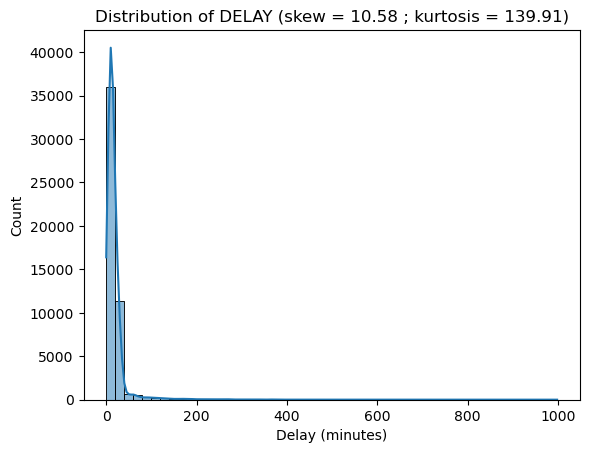

In [16]:
sns.histplot(eda_df['DELAY'], bins=50, kde=True)
plt.title(f"Distribution of DELAY (skew = {eda_df['DELAY'].skew():.2f} ; kurtosis = {eda_df['DELAY'].kurt():.2f})")
plt.xlabel('Delay (minutes)')
plt.show()

With a skewness of 10.58 and a kurtosis of 139.84, our data is is heavily skewed to the right. We observe on the histogram a very long tail on the right confirming the suspicions. However, it is hard to see how many outliers are present in our data. We will use a boxplot to visualize the distribution of `DELAY` and try to answer the question of the number of outliers.


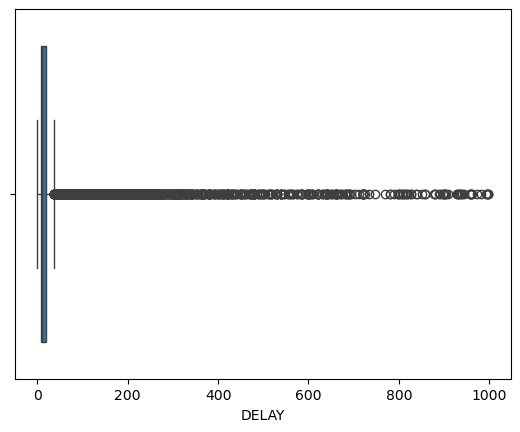

In [17]:
sns.boxplot(x=eda_df['DELAY'])
plt.show()

This boxplot very clearly shows that we have many outliers. 

This very high skewness (10.58) will be problematic in the rest of the EDA if we do not handle it now. We know that we won't have any negative values in our data but we still have zeroes. Since we have a lot of outliers, we cannot simply winsorize our data. To handle the skewness, we will use a log1p transformation on our variables.

We will store the result in a new variable called `DELAY_LOG1P`. This will allow us to compare the distribution of `DELAY` and `DELAY_LOG1P` in the same way during the bivariate and multivariate analysis.

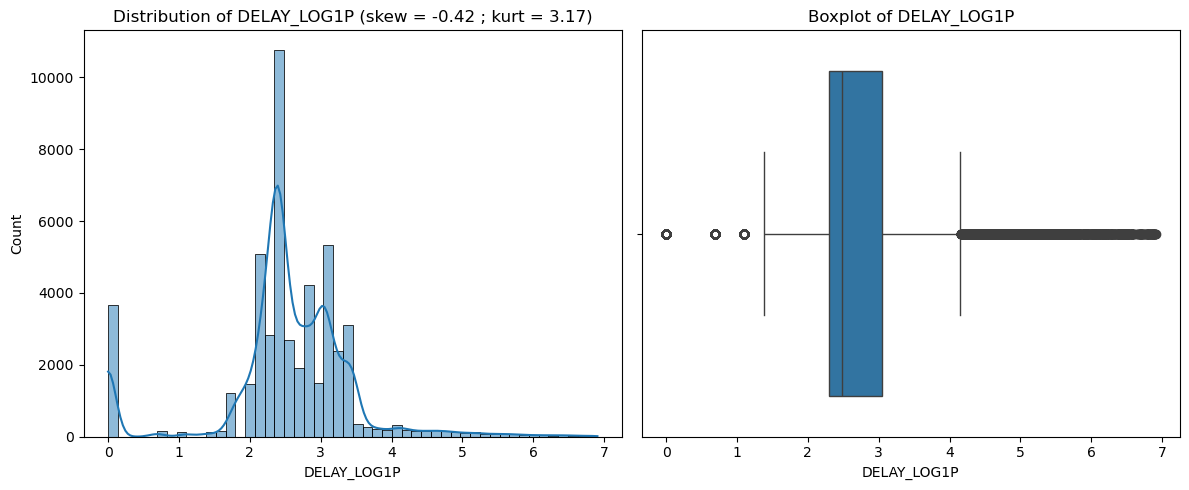

In [18]:
eda_df['DELAY_LOG1P'] = np.log1p(eda_df['DELAY']) 

fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 

sns.histplot(eda_df['DELAY_LOG1P'], bins=50, kde=True, ax=axes[0])
axes[0].set_title(f"Distribution of DELAY_LOG1P (skew = {eda_df['DELAY_LOG1P'].skew():.2f} ; kurt = {eda_df['DELAY_LOG1P'].kurt():.2f})")

sns.boxplot(x=eda_df['DELAY_LOG1P'], ax=axes[1])
axes[1].set_title("Boxplot of DELAY_LOG1P")

plt.tight_layout()
plt.show()

With the skewness now down to -0.42 and the kurtosis being down 3.17, we have a more symmetrical distribution. However this distribution remains a bit leptokurticatic. Even so, this transformation made our data much more usable for later analysis. 

Just like `DELAY`, we will show an overview of this new variable's statistics.

In [19]:
# Basic statistics
print("Basic statistics :")
print(eda_df['DELAY_LOG1P'].describe())

# Missing values
print("\nMissing values :", eda_df['DELAY_LOG1P'].isna().sum())

Basic statistics :
count    49883.000000
mean         2.530170
std          0.971140
min          0.000000
25%          2.302585
50%          2.484907
75%          3.044522
max          6.906755
Name: DELAY_LOG1P, dtype: float64

Missing values : 0


### Temporal variables

#### LOCAL_TIME

**Note :** this variable is used to identify the time of day at which the incident occured but that is not what the variable represents. This variable represents the time at which the incident was **reported**. This slight difference could be the cause of slight inaccuracies in the model.

The variable we are analyzing represents the time of the day at which the incident causing the delay was reported. It is given in the 'HH:MM' format. Before starting the analysis of this data, we should transform it in a datetime.

In [20]:
eda_df['LOCAL_TIME'] = pd.to_datetime(eda_df['LOCAL_TIME'], format='%H:%M').dt.time # transform the time in a datetime object

We also could use the hours of the day and minute separetly to better understand our data. 

In [21]:
eda_df['LOCAL_TIME_HOUR'] = pd.to_datetime(eda_df['LOCAL_TIME'], format='%H:%M:%S').dt.hour 
eda_df['LOCAL_TIME_MINUTE'] = pd.to_datetime(eda_df['LOCAL_TIME'], format='%H:%M:%S').dt.minute

With the data we newly created, we can observe the distribution of delays per hour and by minute.

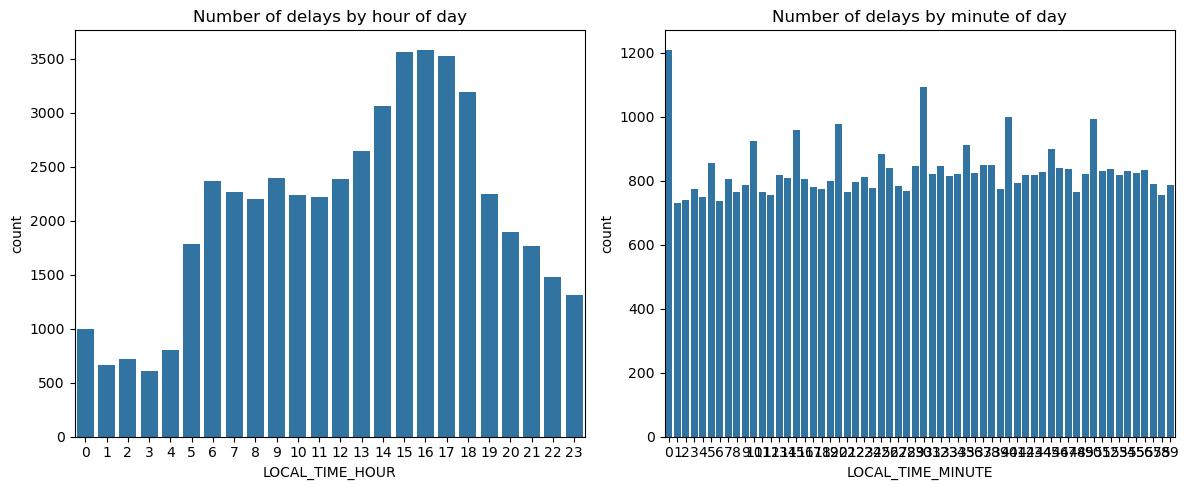

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Count plot of delays by hour
sns.countplot(x='LOCAL_TIME_HOUR', data=eda_df, ax=axes[0])
axes[0].set_title('Number of delays by hour of day')

# Count plot of delays by minute
sns.countplot(x='LOCAL_TIME_MINUTE', data=eda_df, ax=axes[1])
axes[1].set_title('Number of delays by minute of day')

plt.tight_layout()
plt.show()

First of all, we notice that more delays occur around the 15th to 17th hours of the day and less between the 1st to the 4th. This seems coherent since lesser buses should be in activity at night than during the day. 

Another observation that can be made ist that the number of delays increases drastically starting at the 5th hour and decreases at the 19th. This seems once again coherent about what we know about the lifestyle of the average individual. By the 19th hour (7 pm) people came back from their workplace and less traffic is needed or delayed due to human activity.  

We can also detect a continuation from the 23rd hour to midnight, showing the cyclical nature of our data.

Concerning the minutes, not much can be said except for the fact that a lot of incident are being reported during the first minute of the hour or at the half of it. This is probably the result of the data being rounded up to the nearest "significant" minute. This can also be noticed on all the 5th minutes (5, 10, 15, ...) who have spikes of incidents in our data.

#### WEEK_DAY

The week day variable represents the day of the week (i.e "Monday", "Tuesday", ...) at which the incident was reported. 

We start by trying to figure out what days are the most represented in the dataset.

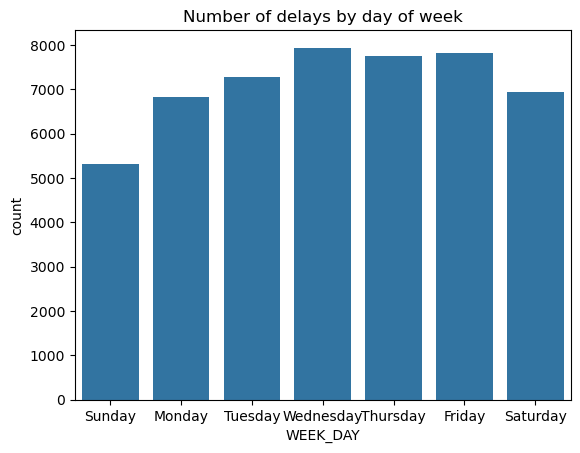

In [23]:
sns.countplot(x='WEEK_DAY', data=eda_df)
plt.title('Number of delays by day of week')

plt.show()

Once again, we notice that the life of the average individual can be found in this plotting. The five workdays have the most delays, with wednesday and friday having the most. Saturday has a lot of incidents too, this could be explained by it being the week-end and buses still having a normal schedule. The sunday is the day with the least incidents. Traditionnally the sunday is the day during which people relax, hece the bus schedules change and there are less buses so less incident reports.

We can also detect the cyclical pattern that occurs in temporal variables. It seems natural that saturday and sunday show a relation to one another since these two days are close in reality.

#### LOCAL_MONTH

The local month variable represents the month during which the incident was reported. The months are already encoded from 1 to 12.

Here again, we want to analyze the distribution of delays per month.

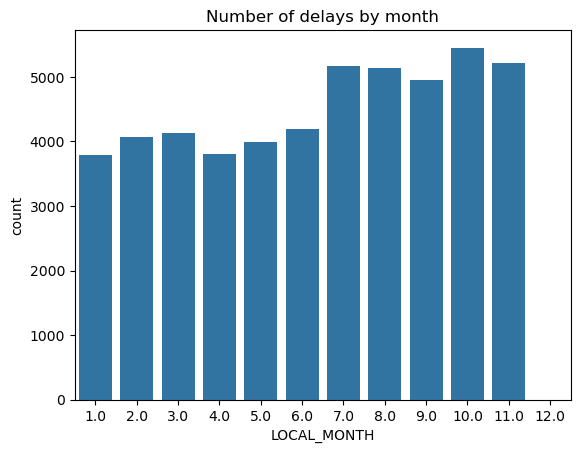

LOCAL_MONTH
1.0     3790
2.0     4065
3.0     4125
4.0     3801
5.0     3997
6.0     4187
7.0     5169
8.0     5130
9.0     4956
10.0    5451
11.0    5210
12.0       2
Name: count, dtype: int64


In [24]:
sns.countplot(x='LOCAL_MONTH', data=eda_df)
plt.title('Number of delays by month')

plt.show()

print(eda_df['LOCAL_MONTH'].value_counts().sort_index())

One noticeable issue is the lack of data for the month of december (only 2 entries). This will undoutebly lead to ineffeciencies in our real life use cases.

**Note :** we could try and simulate fake data the continues the already apparent pattern. The 2022 data of the TTC doesn't include the month of december as well. 

However, it seems odd that January has fewer data than November. These two months being quite close, the number of incidents should appear to be closer. The same goes for June and July, starting July their are more incidents reported overall. This could be the result of estival tourism or an increase in efforts from the TTC to report all their incidents. We do not know for now.

#### LOCAL_DAY

The local day variable represents the day of the month during which the incident was reported (from 1 to 31).

We want to analyze the distribution of delays per day of the month.

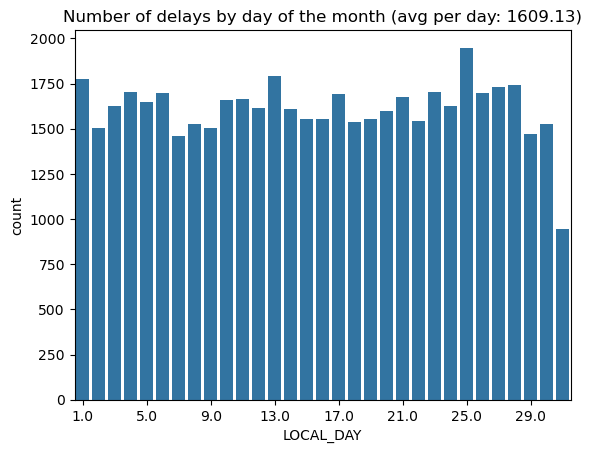

In [25]:
ax = sns.countplot(x='LOCAL_DAY', data=eda_df)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title(f'Number of delays by day of the month (avg per day: {eda_df["LOCAL_DAY"].value_counts().mean():.2f})')

plt.show()

Except for the spikes on the 1st and 24th of the month, the data seems to be rather correclty distributed throughout the months. The 31st day of the month has half as much reports which seems consistent with real life where half the months don't have a 31st day.

### Categorical variables

#### ROUTE

This variable represents the bus route that is concerned by the incident. It is a categorical variable, so we will need to encode it later on.

For now, we are interested by all the possible route names in our dataset.

In [26]:
print("Number of unique routes:", eda_df['ROUTE'].nunique())

print("Unique route names", (eda_df['ROUTE'].value_counts().index.sort_values()))

Number of unique routes: 260
Unique route names Index(['1', '10', '100', '101', '102', '104', '105', '106', '107', '108',
       ...
       'RAD / 501', 'RAD 21', 'RAD 600', 'RSEM', 'SHP', 'SHUTTLE',
       'SHUTTLE BUS - LINE 2', 'SRT', 'SRT SHUTTE LINE 3', 'YU'],
      dtype='object', name='ROUTE', length=260)


We encounter an issue concerning the route names. Most of the route names are strings representing a numerical value while some of them do not.

Before going further, we want to know what type of representation for the route names is the most used.

Number of numeric ROUTE values: ROUTE
True     49669
False      214
Name: count, dtype: int64

Proportion of numeric ROUTE values: ROUTE
True     99.570996
False     0.429004
Name: proportion, dtype: float64


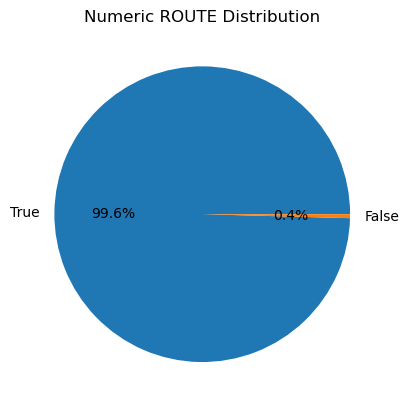

In [27]:
strictly_numerical_route_filter = eda_df['ROUTE'].astype(str).str.isdigit()

print("Number of numeric ROUTE values:" , strictly_numerical_route_filter.value_counts())
print("\nProportion of numeric ROUTE values:" , strictly_numerical_route_filter.value_counts(normalize=True) * 100)

plt.pie(
    strictly_numerical_route_filter.value_counts(), 
    labels=strictly_numerical_route_filter.value_counts().index, 
    autopct="%.1f%%",     # show percentages
)

plt.title("Numeric ROUTE Distribution")
plt.show()

We notice that the overwhelming majority of the route names are numerical while 0.4% are strings. Some of these strings represent routes (i.e "Line 1", "RAD 21", ...) and a simple transformation could convert them to a normalized route number. Others however represent something else than a route number (i.e "SHP", "RSEM", "SHUTTLE", ...). 

By dropping the entire non-numerical values, we would lose 0.4% of our data. To try and prevent this, we will try to transform all the string values that contains a number to this simple number (i.e "Line 1" becomes "1").

Before doing that transformation, we should know beforehand the repartition of our non-numerical values in the dataset and the different values taken. 

In [28]:
not_numerical_route_filter = ~strictly_numerical_route_filter

# Regex that matches any digit in a string surrounded by word boundaries (space, end of string, start of string, punctuation, etc.)
regex = r'\b\d+\b'

# Count how many non-numeric routes contain numbers
nn_route_has_number = eda_df[not_numerical_route_filter]['ROUTE'].str.contains(regex, regex=True)
print(f"\nNon-numeric routes that contain numbers: {nn_route_has_number.sum()} ({(nn_route_has_number.sum() / not_numerical_route_filter.sum()) * 100:.2f}%)")
print(f"Non-numeric routes without numbers: {(~nn_route_has_number).sum()} ({((~nn_route_has_number).sum() / not_numerical_route_filter.sum()) * 100:.2f}%)")

# Show routes without numbers
print("\nRoutes without any numbers:")
print(eda_df[not_numerical_route_filter][~nn_route_has_number]['ROUTE'].unique())


# Show routes with numbers
print("\nRoutes with numbers:")
print(eda_df[not_numerical_route_filter][nn_route_has_number]['ROUTE'].unique())



Non-numeric routes that contain numbers: 112 (52.34%)
Non-numeric routes without numbers: 102 (47.66%)

Routes without any numbers:
['RAD' 'SHUTTLE' 'A236' 'OTC' 'RSEM' 'FLEET' 'YU' 'BD' 'NON' 'SHP'
 'HILLCREST' 'BROADVIEW' 'SRT' 'CARIBANA' 'A' 'LINE1' 'CHANGEOF']

Routes with numbers:
['RAD 600' 'LINE 1' 'RAD 21' 'LIINE 1' 'LINE 2' 'SHUTTLE BUS - LINE 2'
 'RAD / 501' 'LINE 3' 'SRT SHUTTE LINE 3' '600 - ROUTE LINE 1'
 '927 HIGHWAY 27' '600 (75' 'LINE 1 SHUTTLE - 600' '600 - ROUTE 301'
 '52 LAWRENCE WEST - 600']


Now that we know what data to transform, we encounter one last problem. Some of these values have ambiguity. For example "52 LAWRENCE WEST - 600" or "600 (75" are not clear on what route is concerned here. 

Since the non-numerical values only represent 0.4% of our dataset, we prefer to drop all the non-numerical data to avoid the pollution of our dataset from an ill-conceived transformation.

In [29]:
before_drop_shape = eda_df.shape
# Dropping the rows not numerical routes
eda_df = eda_df.drop(index=eda_df[not_numerical_route_filter].index)

# Verify the result
print(f"Shape after dropping rows with missing data: {eda_df.shape} / previous shape: {before_drop_shape} (dropped {before_drop_shape[0] - eda_df.shape[0]} rows)")

Shape after dropping rows with missing data: (49669, 20) / previous shape: (49883, 20) (dropped 214 rows)


#### INCIDENT

The `INCIDENT` variable describes in plain text the incident type causing the current delay. 

We are interested in observing it's different modalities to clrify what type of incidents are taken into account in our data. 

Number of unique incidents: 13
Unique incident names Index(['Cleaning - Unsanitary', 'Collision - TTC', 'Diversion',
       'Emergency Services', 'General Delay', 'Held By', 'Investigation',
       'Mechanical', 'Operations - Operator',
       'Road Blocked - NON-TTC Collision', 'Security', 'Utilized Off Route',
       'Vision'],
      dtype='object', name='INCIDENT')


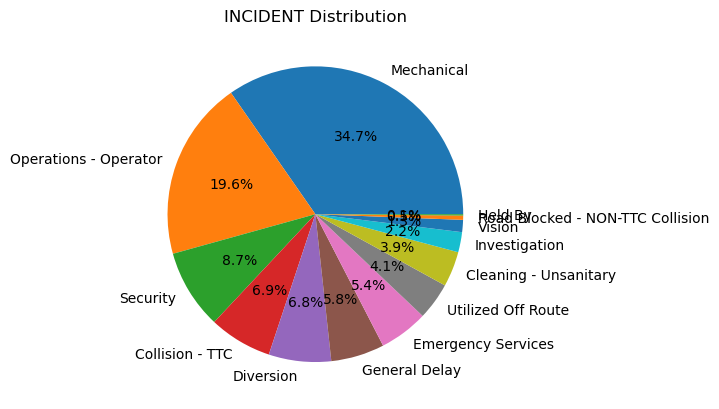

In [30]:
print("Number of unique incidents:", eda_df['INCIDENT'].nunique())

print("Unique incident names", (eda_df['INCIDENT'].value_counts().index.sort_values()))

plt.pie(
    eda_df['INCIDENT'].value_counts(), 
    labels=eda_df['INCIDENT'].value_counts().index, 
    autopct="%.1f%%",     # show percentages
)

plt.title("INCIDENT Distribution")
plt.show()

In total, we count 13 modalities. This can be a bit much so we decide to regroup them into broader categories :

* Safety (Collision - TTC, Security, Emergency Services, Investigation)
* Operational (Operations - Operator, Held By, Utilized Off Route)
* Technical (Mechanical, Cleaning - Unsanitary)
* External (Road Blocked - NON-TTC Collision, Diversion)
* Other (General Delay, Vision)

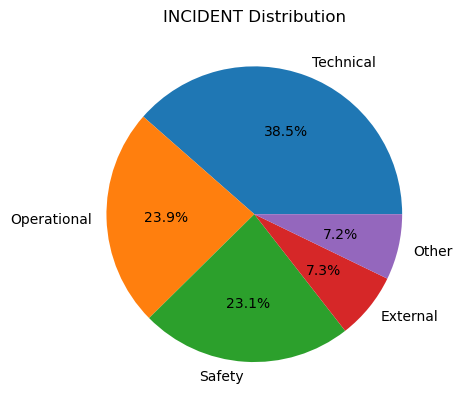

In [31]:
incident_map = {
    'Cleaning - Unsanitary': 'Technical',
    'Collision - TTC': 'Safety', 
    'Diversion': 'External',
    'Emergency Services': 'Safety', 
    'General Delay': 'Other', 
    'Held By': 'Operational', 
    'Investigation': 'Safety',
    'Mechanical': 'Technical', 
    'Operations - Operator': 'Operational',
    'Road Blocked - NON-TTC Collision': 'External', 
    'Security': 'Safety', 
    'Utilized Off Route': 'Operational',
    'Vision': 'Other'
}

eda_df['INCIDENT'] = eda_df['INCIDENT'].apply(
    lambda incident: incident_map.get(incident, incident)
)

plt.pie(
    eda_df['INCIDENT'].value_counts(), 
    labels=eda_df['INCIDENT'].value_counts().index, 
    autopct="%.1f%%",     # show percentages
)

plt.title("INCIDENT Distribution")
plt.show()

#### WEATHER_ENG_DESC

The `WEATHER_ENG_DESC` variable describes in plain text the weather conditions during the incident. 

We are interested in observing the different modalities of weather conditions. 

In [32]:

print("Number of unique weather descriptions: ", eda_df['WEATHER_ENG_DESC'].nunique())
print(eda_df['WEATHER_ENG_DESC'].value_counts())

Number of unique weather descriptions:  24
WEATHER_ENG_DESC
Clear                              42326
Rain                                2458
Snow                                1467
Rain,Fog                            1205
Fog                                 1048
Haze                                 595
Moderate Rain,Fog                    139
Moderate Snow                        106
Thunderstorms,Rain                    72
Thunderstorms                         67
Freezing Rain,Fog                     51
Moderate Rain                         45
Freezing Rain                         21
Thunderstorms,Moderate Rain,Fog       12
Thunderstorms,Freezing Rain            9
Thunderstorms,Rain,Fog                 7
Thunderstorms,Moderate Rain            7
Thunderstorms,Heavy Rain,Fog           7
Heavy Rain                             6
Rain,Snow                              6
Freezing Rain,Snow                     5
Freezing Fog                           4
Heavy Rain,Fog                        

We have many modalities in this dataset, it could be interseresting to decrease the number of categories.

First of all, we should make a new variable called `WEATHER_ENG_DESC_LIST` that contains a list of all the weather conditions rather than just having category with a comma separating the different weather conditions.

In [33]:
eda_df['WEATHER_ENG_DESC_LIST'] = eda_df['WEATHER_ENG_DESC'].str.split(',')
eda_df['WEATHER_ENG_DESC_LIST'].value_counts().head(10)

WEATHER_ENG_DESC_LIST
[Clear]                  42326
[Rain]                    2458
[Snow]                    1467
[Rain, Fog]               1205
[Fog]                     1048
[Haze]                     595
[Moderate Rain, Fog]       139
[Moderate Snow]            106
[Thunderstorms, Rain]       72
[Thunderstorms]             67
Name: count, dtype: int64

With this being done, we can now observe how many time each condition appears (individually).

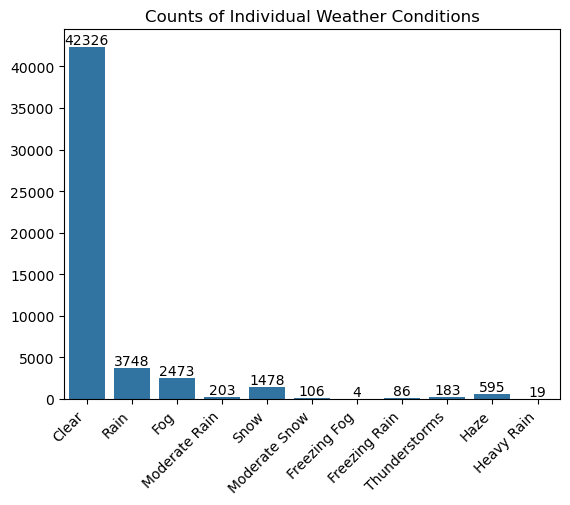

In [34]:
weather_counts = Counter([condition for sublist in eda_df['WEATHER_ENG_DESC_LIST'] for condition in sublist])

ax = sns.barplot(x=list(weather_counts.keys()), y=list(weather_counts.values()))

# We add the value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.title("Counts of Individual Weather Conditions")
plt.xticks(rotation=45, ha='right')    
plt.show()

Some of these weather conditions appear very rarely in our data (for example, freezing fog, heavy rain or freezing rain).

To capture the broader nature of these events, we will regroup the different conditions into categories.
We will use the following categories:

* Rain (Rain, Moderate Rain, Freezing Rain, Heavy Rain)
* Fog (Fog, Freezing Fog, Haze)
* Snow (Snow, Moderate Snow)
* Thunderstorms 
* Clear

In [35]:
weather_map = {
    'Moderate Rain': 'Rain',
    'Freezing Rain': 'Rain',
    'Heavy Rain': 'Rain',
    'Freezing Fog': 'Fog',
    'Haze': 'Fog',
    'Moderate Snow': 'Snow'
}

eda_df['WEATHER_ENG_DESC_LIST'] = eda_df['WEATHER_ENG_DESC_LIST'].apply(
    lambda lst: [weather_map.get(condition, condition) for condition in lst]
)

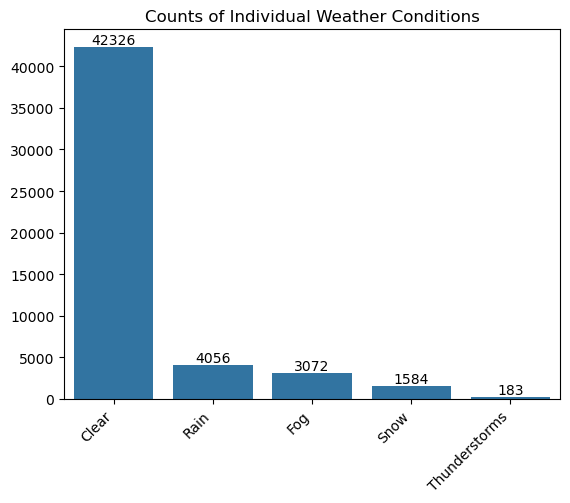

In [36]:
# We replot the counts of individual weather conditions after mapping
weather_counts = Counter([condition for sublist in eda_df['WEATHER_ENG_DESC_LIST'] for condition in sublist])

ax = sns.barplot(x=list(weather_counts.keys()), y=list(weather_counts.values()))

# We add the value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.title("Counts of Individual Weather Conditions")
plt.xticks(rotation=45, ha='right')    
plt.show()

The addition to this new variable should make the effect of the weather conditions on the delays clearer during the bivariate analysis later on.

### Numerical variables

In [37]:
def basic_numerical_analysis(df, column_name, show_stats=True, missing_data=False, name=None):
    if name is None:
        name = column_name
    # Basic statistics
    if show_stats:
        print("Basic statistics :")
        print(df[column_name].describe())

    # Missing values
    if missing_data:
        print(f"\nNumber of missing values in {column_name}: {df[column_name].isna().sum()} ({df[column_name].isna().mean() * 100:.2f}%)")

    # For the distribution and the outliers
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.histplot(df[column_name], kde=True, ax=axes[0])
    axes[0].set_title(f"Distribution of {name} (skew = {df[column_name].skew():.2f} ; kurtosis = {df[column_name].kurt():.2f})")

    sns.boxplot(x=df[column_name], ax=axes[1])
    axes[1].set_title(f"Boxplot of {name}")

    plt.tight_layout()
    plt.show()

#### TEMP

This variable represents the temperature in degrees Celsius (°C) at which the incident occured.

Basic statistics :
count    49669.000000
mean        11.746101
std          9.176368
min        -20.000000
25%          3.700000
50%         12.200000
75%         20.000000
max         32.000000
Name: TEMP, dtype: float64


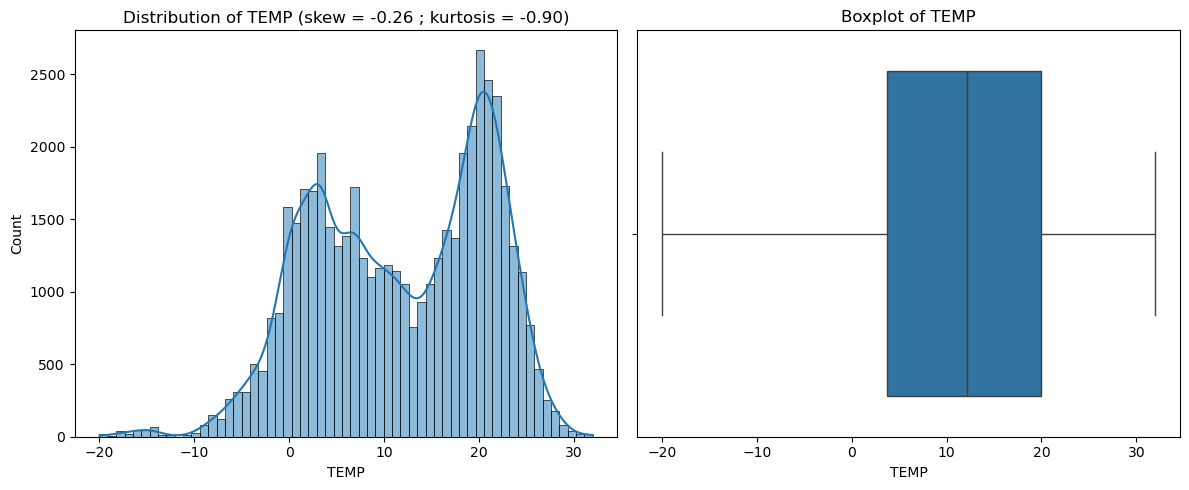

In [38]:
basic_numerical_analysis(eda_df, 'TEMP')

First of all, the data seems coherent with the south of Canada's climate (no temperature having to extreme or incoherent values like 45°C or -30°C).

**Distribution shape** : The distribution is slightly left-skewed (skew = -0.26) but is still close to symmetric. A small tail is extending to negative values (around -10°C).
There are two visible modes indicating a bimodal distribution: one around 5°C and another around 20°C. This could be due to day/night and summer/winter readings.  

**Peakedness** : Having a negative kurtosis (-0.90), the distribution is slightly platykurtic. The tails are quite light and the peaks less sharp than a normal distribution. This also indicates that most values are spread around the two modes and not around the mean.

**Boxplot** : The median stands at 12.2°C while the Q1 and Q3 cover 3.7°C to 20°C. The whiskers extend to -20°C and 32°C, showing no obvious outliers but showing the negative tail with the left whisker.

In summary, the temperature variable is bimodal, which can be a problem for models that are sensitive to normality. The distribution is flatter than normal and no extreme outliers have been found.

Our intuition is that the bimodality is due to the seasons. To check our theory, we plot the distribution of TEMP in summer and winter.

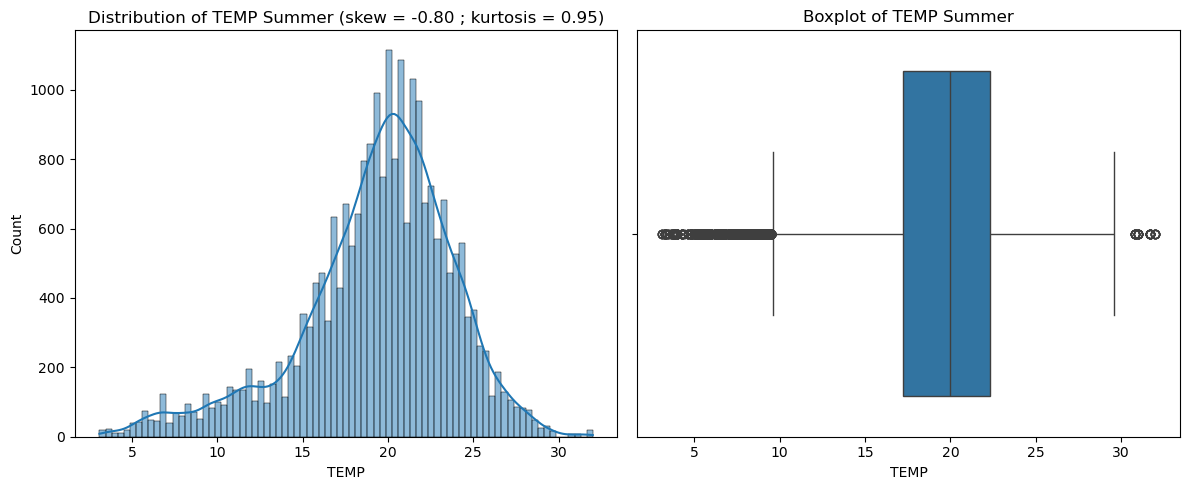

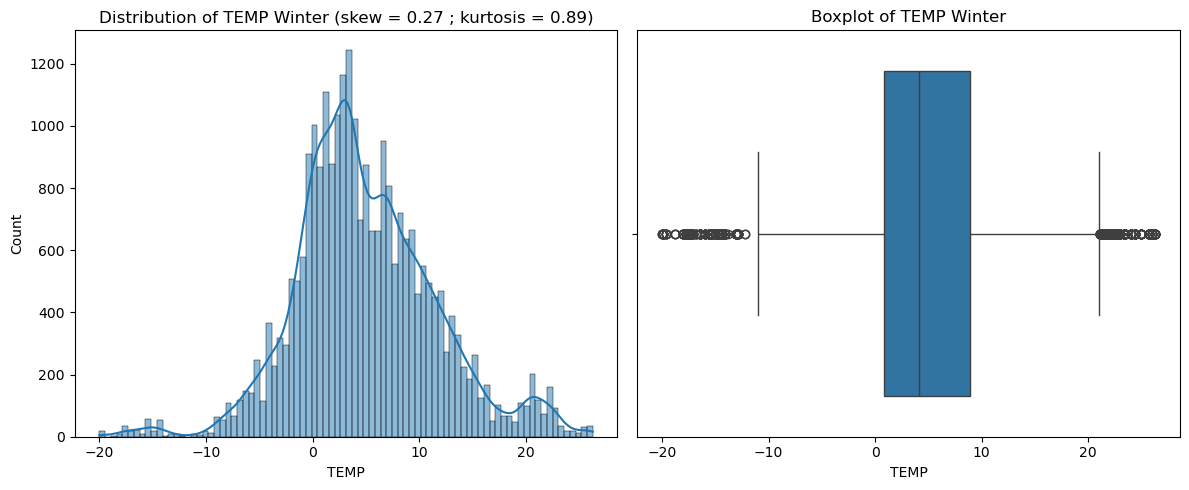

In [39]:
# We will reuse these filters later on in other analysis
summer_filter = eda_df['LOCAL_MONTH'].isin([5, 6, 7, 8, 9])
winter_filter = ~summer_filter

basic_numerical_analysis(eda_df[summer_filter], 'TEMP', show_stats=False, name='TEMP Summer')
basic_numerical_analysis(eda_df[winter_filter], 'TEMP', show_stats=False, name='TEMP Winter')

Overall, we notice that our intuition was right, we have now two more "gaussian-like" curves representing the distribution of the temperatures in summer and winter. However, both seasons have many outliers. This is probably due to the way we splitted the year into only two seasons ("extreme" temperatures at start and end of seasons).

#### DEW_POINT_TEMP

This variable represents the dew point temperature in degrees Celsius (°C) at which the incident occured.

Basic statistics :
count    49669.000000
mean         6.591586
std          9.118308
min        -27.700000
25%         -0.300000
50%          6.500000
75%         14.500000
max         23.400000
Name: DEW_POINT_TEMP, dtype: float64


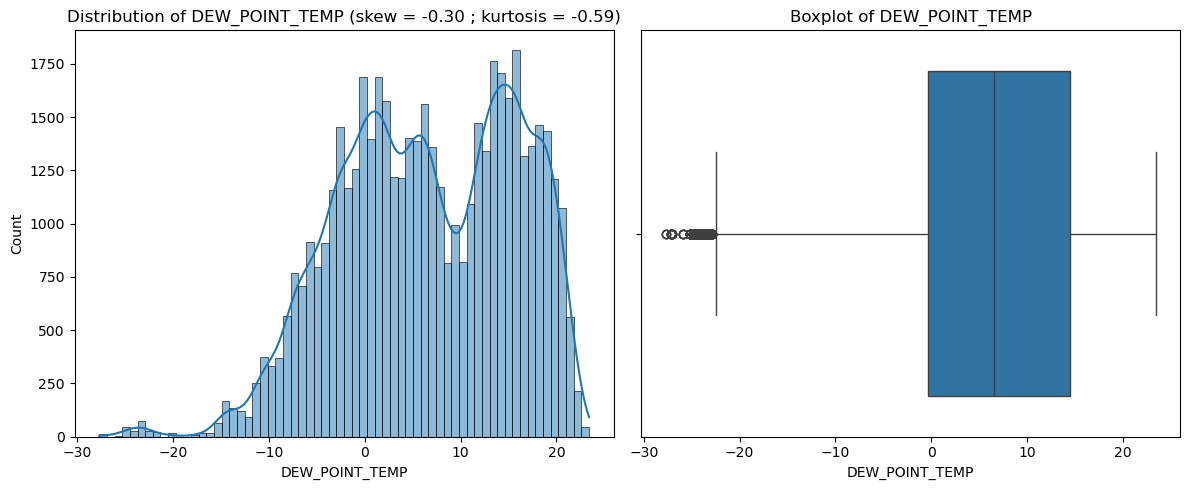

In [40]:
basic_numerical_analysis(eda_df, 'DEW_POINT_TEMP')

**Distribution shape** : The distribution is slightly left-skewed (skew = -0.30) but is still close to symmetric. A small tail is extending to negative values (around -10°C).
There are two visible modes indicating a bimodal distribution: one around 0°C and another around 15°C. This could be due to day/night and summer/winter readings.  

**Peakedness** : Having a negative kurtosis (-0.59), the distribution is slightly platykurtic. The tails are quite light (there is no right tail) and the peaks less sharp than a normal distribution. This also indicates that most values are spread around the two modes and less around the mean.

**Boxplot** : The median stands at 6.5°C while the Q1 and Q3 cover -0.3°C to 14.5°C. The whiskers extend to around -22/-23°C and 23.4°C, showing multiple outliers on the left and the left tail with the left whisker.

In summary, the dew point temperature variable is bimodal, which can be a problem for models that are sensitive to normality. The distribution is flatter than normal and we encounter some extreme outliers. 

Same as for TEMP, we observe what the distribution looks like when splitting the dataset between summer and winter.

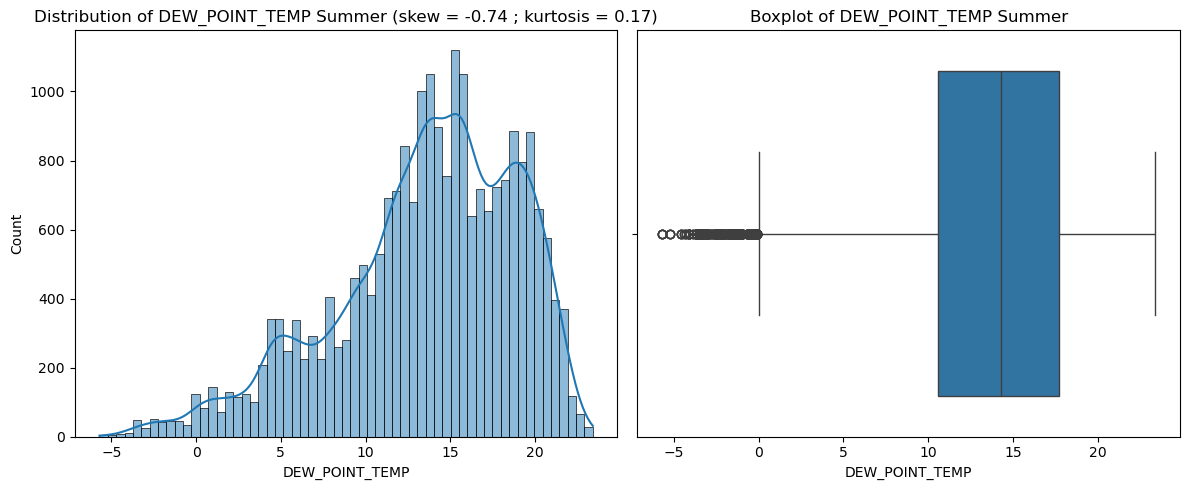

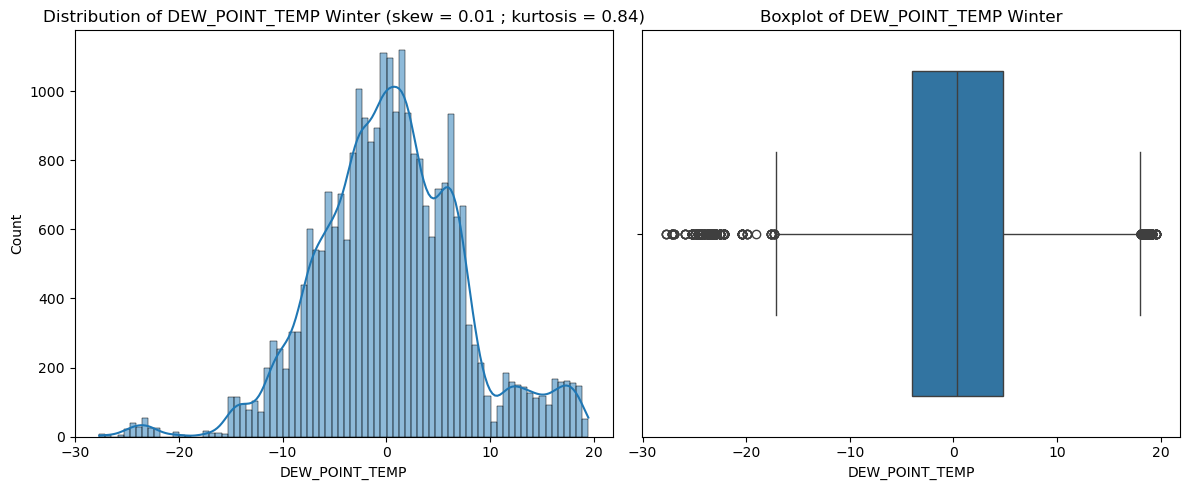

In [41]:
basic_numerical_analysis(eda_df[summer_filter], 'DEW_POINT_TEMP', show_stats=False, name='DEW_POINT_TEMP Summer')
basic_numerical_analysis(eda_df[winter_filter], 'DEW_POINT_TEMP', show_stats=False, name='DEW_POINT_TEMP Winter')

We got rid of the bimodality for the most part but there are still some residus of it in both the distributions. But overall, we once again got a "normal" looking curves with more outliers.

#### HUMIDEX

This variable represents the humidex index at which the incident occured.

**Note :** it is important to remember that we recalculated this entire variable by using the formla given by the canadian government on the dataset's documentation. 

Basic statistics :
count    49669.000000
mean        12.565678
std         12.515075
min        -25.193084
25%          1.563831
50%         12.091444
75%         23.806026
max         40.079408
Name: HUMIDEX, dtype: float64


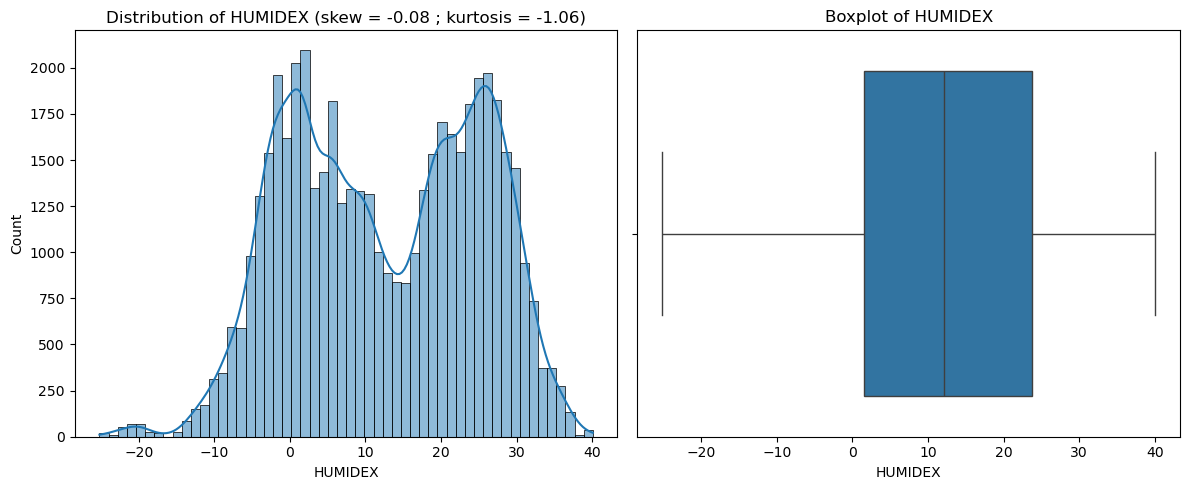

In [42]:
basic_numerical_analysis(eda_df, 'HUMIDEX')

**Distribution shape** : The distribution is very slightly left-skewed (skew = -0.08) but is still symmetric. A small tail is extenting to negative values (around -15°C).
There are two visible modes indicating a bimodal distribution: one around 2°C and another around 25°C. This could be due to day/night and summer/winter readings.  

**Peakedness** : Having a negative kurtosis (-1.06), the distribution is platykurtic. The tails are quite light (there is almost no right tail) and the peaks less sharp than a normal distribution. This also indicates that most values are spread around the two modes and not around the mean.

**Boxplot** : The median stands at 12.1°C while the Q1 and Q3 cover 1.6°C to 24.9°C. The whiskers extend to around -22/-23°C and 23.4°C, showing no extreme outliers but showing the negative tail with the left whisker.

In summary, the humidex index variable is bimodal, which can be a problem for models that are sensitive to normality. The distribution is flatter than normal and we encounter no extreme outliers. 

Same as for the two previous features, we observe what the distribution looks like when splitting the dataset between summer and winter.

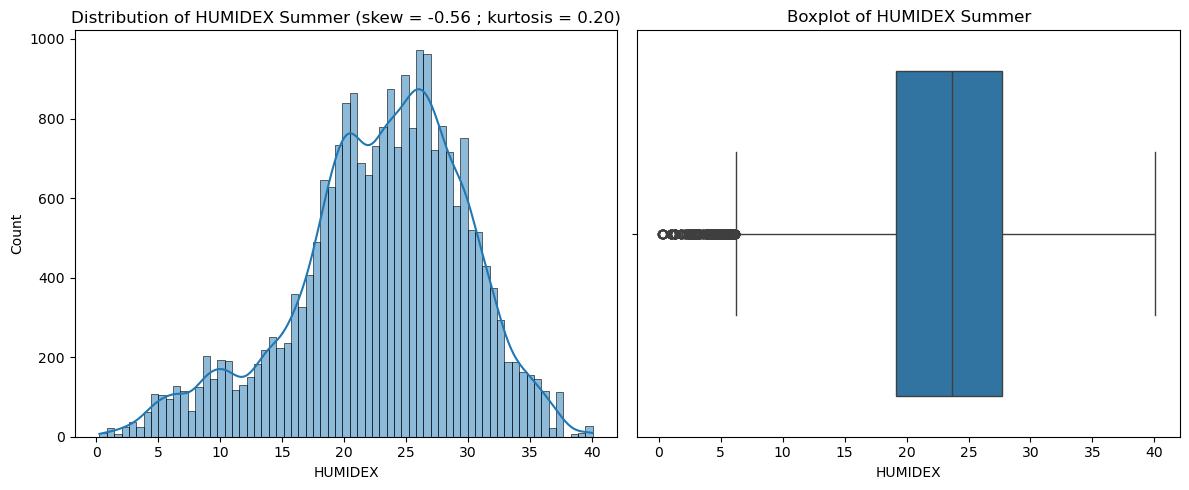

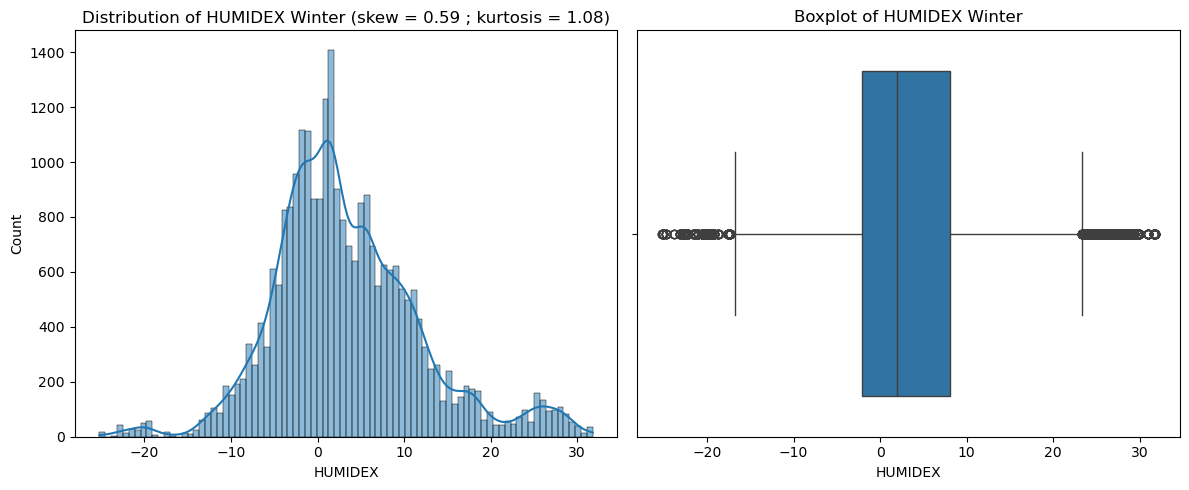

In [43]:
basic_numerical_analysis(eda_df[summer_filter], 'HUMIDEX', show_stats=False, name="HUMIDEX Summer")
basic_numerical_analysis(eda_df[winter_filter], 'HUMIDEX', show_stats=False, name="HUMIDEX Winter")

We got rid of the bimodality for the most part but there are still some residus of it for the summer distribution. But overall, we once again got a "normal" looking curves with more outliers.

#### PRECIP_AMOUNT

This variable represents the amount of precipitations in millimeters (mm) at the time of the incident.

Basic statistics :
count    49669.000000
mean         0.097630
std          0.548907
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         15.900000
Name: PRECIP_AMOUNT, dtype: float64


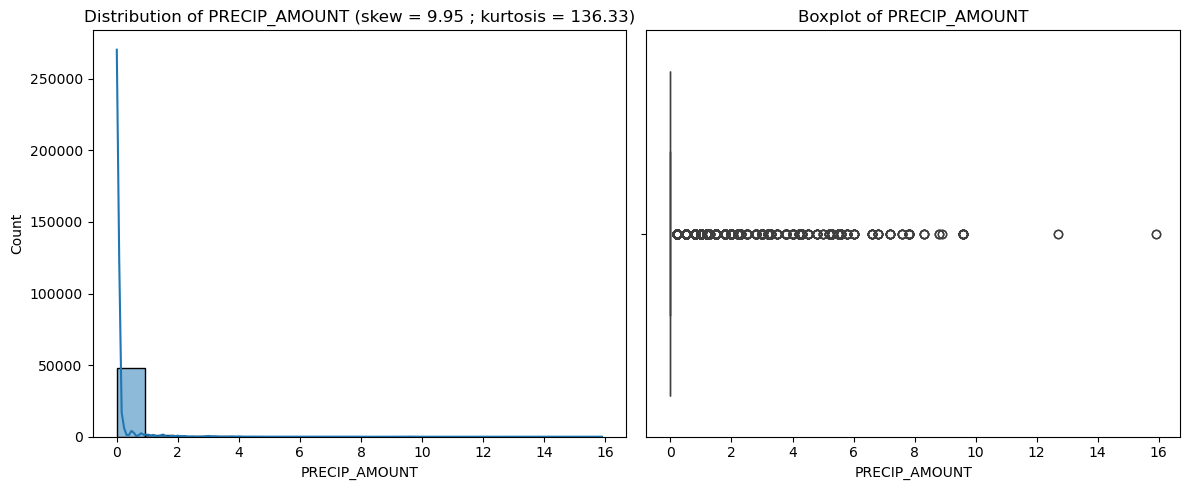

In [44]:
basic_numerical_analysis(eda_df, 'PRECIP_AMOUNT')

We immediatly notice that this variable is heavily unbalanced, with the median, Q1 and Q3 having the same value. Having very few entries of precipitation measurments. 

This variable is of no use from a numerical standpoint, there are to few cases of precipitations and to many entries for no precipitations. 

However, if we were to turn it to a binary variable `PRECIPITATIONS` such as if `PRECIP_AMOUNT` > 0 then `PRECIPITATIONS`=True, maybe we could use this data. 

Proportion of entries with precipitations: 7.95%


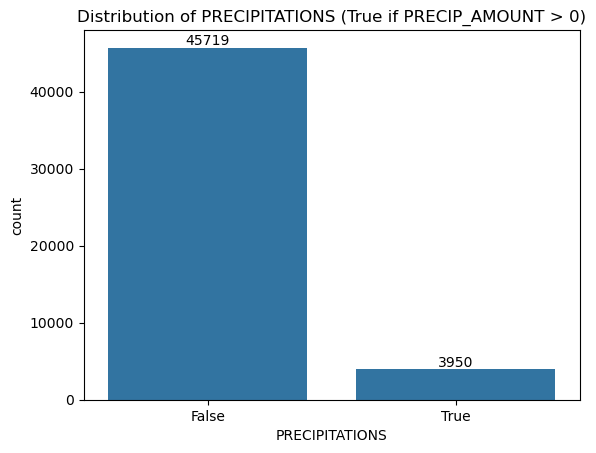

In [45]:
eda_df['PRECIPITATIONS'] = eda_df['PRECIP_AMOUNT'] > 0

print("Proportion of entries with precipitations: {:.2f}%".format(eda_df['PRECIPITATIONS'].mean() * 100))

ax = sns.countplot(x='PRECIPITATIONS', data=eda_df)
plt.title('Distribution of PRECIPITATIONS (True if PRECIP_AMOUNT > 0)')

# We add the value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.show()

test = 12

The presence of precipitations is still low (7.95%) but is now exploitable.

#### RELATIVE_HUMIDITY

This variable represents the relative humidity in the air in percents at the time of the incident.

Basic statistics :
count    49669.000000
mean        72.115666
std         14.635637
min         21.000000
25%         63.000000
50%         73.000000
75%         83.000000
max        100.000000
Name: RELATIVE_HUMIDITY, dtype: float64


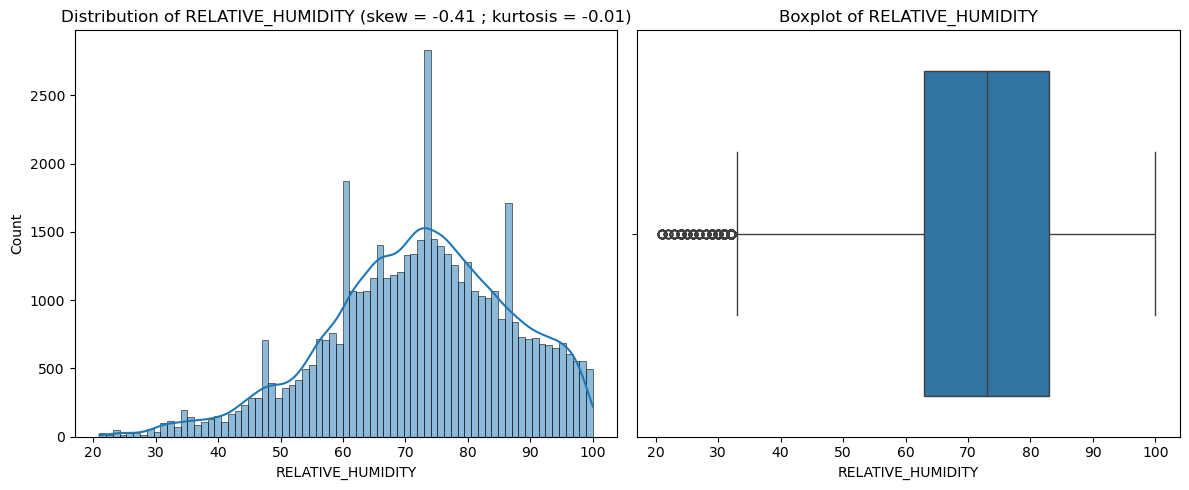

In [46]:
basic_numerical_analysis(eda_df, 'RELATIVE_HUMIDITY')

**Distribution shape** : The distribution is very slightly left-skewed (skew = -0.41) but is still symmetric. A small tail is extenting to negative values (around 40%). There are 3 significant spikes at 60%, 73% and 87% thet we cannot explain as of now.

**Peakedness** : Having an almost nul kurtosis (-0.01), the distribution is mesokurtic. There are supposedly no tails (there is no right tail) and the peak should be as sharp than a normal distribution. However, it seems there is a bit of a tail around 30%. But still, even with the spikes, there is only one significant peak in this variable.

**Boxplot** : The median stands at 73% while the Q1 and Q3 cover 63% to 83°C. The whiskers extend to around 33% and 100%. The boxplot shows a negative tail with its left whisker and some outliers. These outliers are few compared to the rest of the values.

In summary, the relative humidity variable follows a normal distribution with a mean of 72.1 and a standard deviation of 14.6. The distribution has a few spikes in values that we do not fully understand for now and has few extreme outliers.

#### STATION_PRESSURE

This variable represents the atmospheric pressure in kilopascals (kPa) at the measuring station's height during the incident.

Basic statistics :
count    49669.000000
mean       100.575559
std          0.768266
min         97.760000
25%        100.090000
50%        100.580000
75%        101.130000
max        102.870000
Name: STATION_PRESSURE, dtype: float64


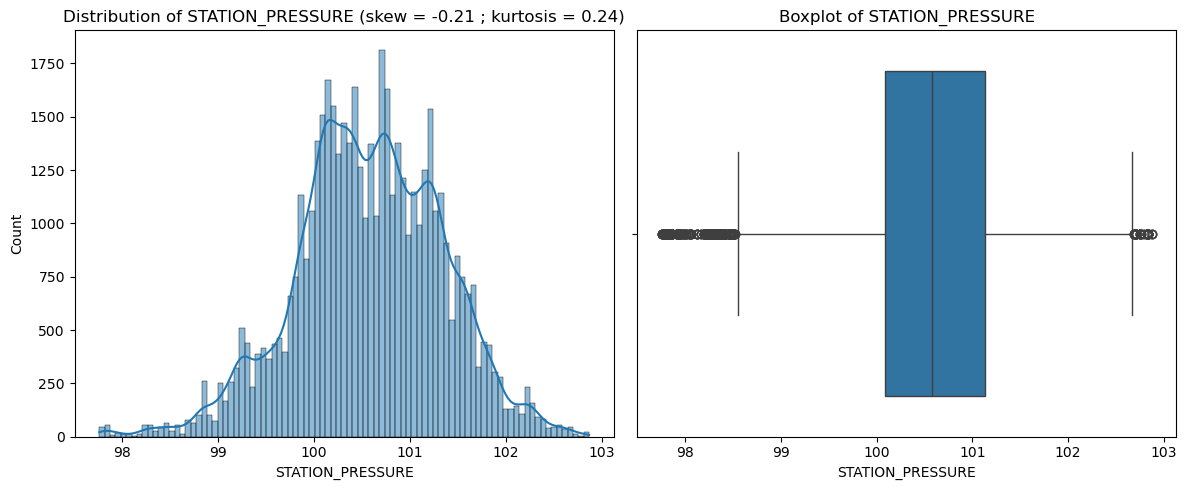

In [47]:
basic_numerical_analysis(eda_df, 'STATION_PRESSURE')

**Distribution shape** : The distribution is very slightly left-skewed (skew = -0.21) but is still symmetric. Two small tails are extenting on the left and rights.

**Peakedness** : Having a positive kurtosis (0.24), the distribution is sligthly leptokurtic. The tails are quite longer and the peak is more sharp than a normal distribution. This also is an indicator for the presence of outliers.

**Boxplot** : The median stands at 100.58kPa while the Q1 and Q3 cover 100.09kPa to 101.13kPa. The whiskers extend to around 98.5kPa and 102.5kPa. The boxplot shows well balanced whiskers but a lot of outliers on both sides of the whiskers.

In summary, the atmospheric pressure variable seems to almost follow a normal distribution with a mean of 100.57kPa and a standard deviation of 0.77. The distribution has a few spikes in values that we do not fully understand for now and has few extreme outliers. 

To try to diminish the number of outliers, we can try to do a Box-Cox tranformation of the data.


#### VISIBILITY

This feature represents the distance in kilometers (km) at which objects of suitable size can be identified at the time of the incident.

Basic statistics :
count    49659.000000
mean        15.131708
std          3.002419
min          0.200000
25%         16.100000
50%         16.100000
75%         16.100000
max         16.100000
Name: VISIBILITY, dtype: float64


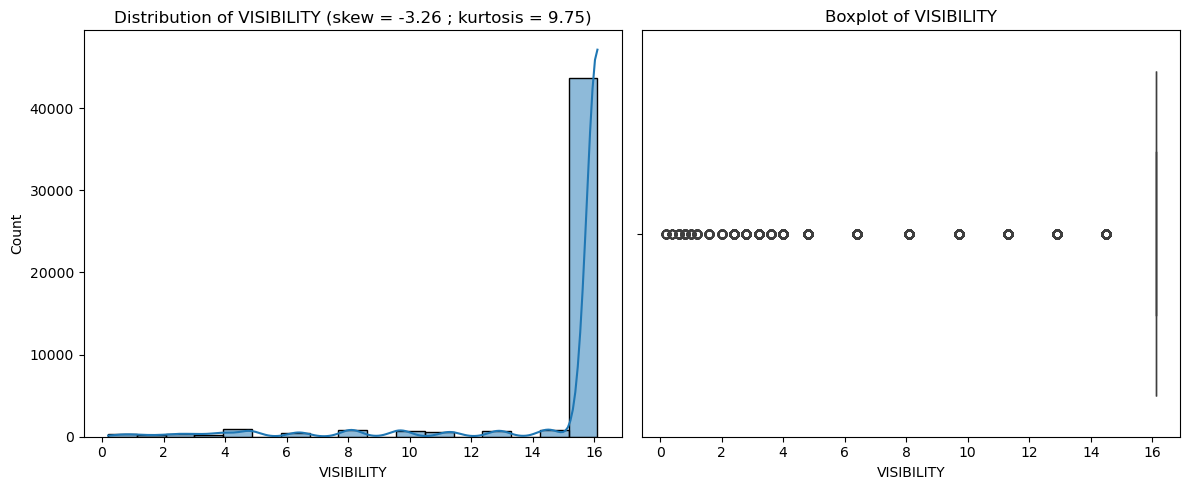

In [48]:
basic_numerical_analysis(eda_df, 'VISIBILITY')

We immediatly notice that this variable is heavily unbalanced, with the median, Q1 and Q3 having the same value. Howevern we still dispose of some data concerning the visibility.

This variable is of no use from a numerical standpoint, the grand majority of the values are of 16km with little values under it and none above. 

However, if we were to turn this feature into a categorical variable `VISIBILITY_DESC` with the following rules :

* 16km <= `VISIBILITY`  : "Great visibility" 
* 12km <= `VISIBILITY` < 16km : "Correct visibility" 
* 8km <= `VISIBILITY` < 12km : "Poor visibility" 
* 4km <= `VISIBILITY` < 8km : "Very poor visibility" 
* 0km <= `VISIBILITY` < 4km : "No visibility"

We could succeed in exploiting this variable.

Proportion of each category in VISIBILITY_DESC:
 VISIBILITY_DESC
Great visibility        87.835471
Poor visibility          4.046790
Correct visibility       2.947513
Very poor visibility     2.941473
No visibility            2.228754
Name: proportion, dtype: float64


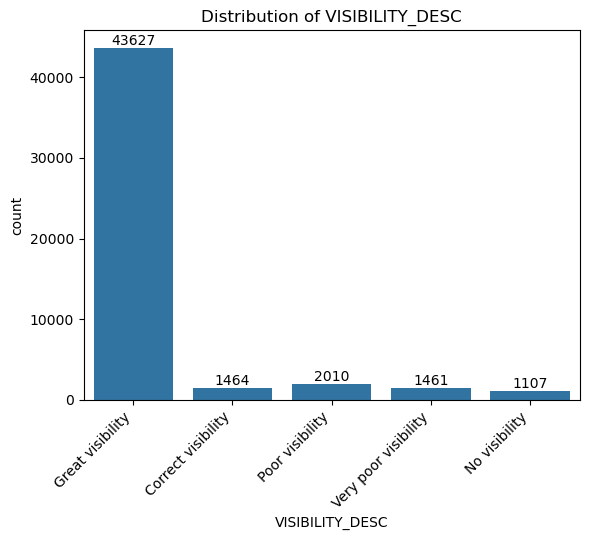

In [49]:
def visibility_to_visibility_desc(visibility):
    if 16 <= visibility:
        return "Great visibility"
    elif 12 <= visibility:
        return "Correct visibility"
    elif 8 <= visibility:
        return "Poor visibility"
    elif 4 <= visibility:
        return "Very poor visibility"
    else:
        return "No visibility"

# Create the VISIBILITY_DESC categorical variable
eda_df['VISIBILITY_DESC'] = eda_df['VISIBILITY'].apply(visibility_to_visibility_desc)

# Show the proportion of each category
print('Proportion of each category in VISIBILITY_DESC:\n', eda_df['VISIBILITY_DESC'].value_counts(normalize=True) * 100)

# Plot the distribution of VISIBILITY_DESC
ax = sns.countplot(x='VISIBILITY_DESC', data=eda_df, order=['Great visibility', 'Correct visibility', 'Poor visibility', 'Very poor visibility', 'No visibility'])
plt.title('Distribution of VISIBILITY_DESC')

# We add the value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.xticks(rotation=45, ha='right')
plt.show()

The visibilities other than "Great visibility" represent approximatively 12% of the data. By taking only 5 possible values, this variable would come in useful later on during the bivariate analysis.

**Note :** the `VISIBILITY_DESC` feature is of type ordinal categorical, this should be kept in mind for the encoding process.  

#### WIND_DIRECTION

This feature represents the wind direction in tens of degrees at the time of the incident.

Basic statistics :
count    48077.000000
mean        19.935645
std          9.938159
min          0.000000
25%          9.000000
50%         21.000000
75%         29.000000
max         36.000000
Name: WIND_DIRECTION, dtype: float64

Number of missing values in WIND_DIRECTION: 1592 (3.21%)


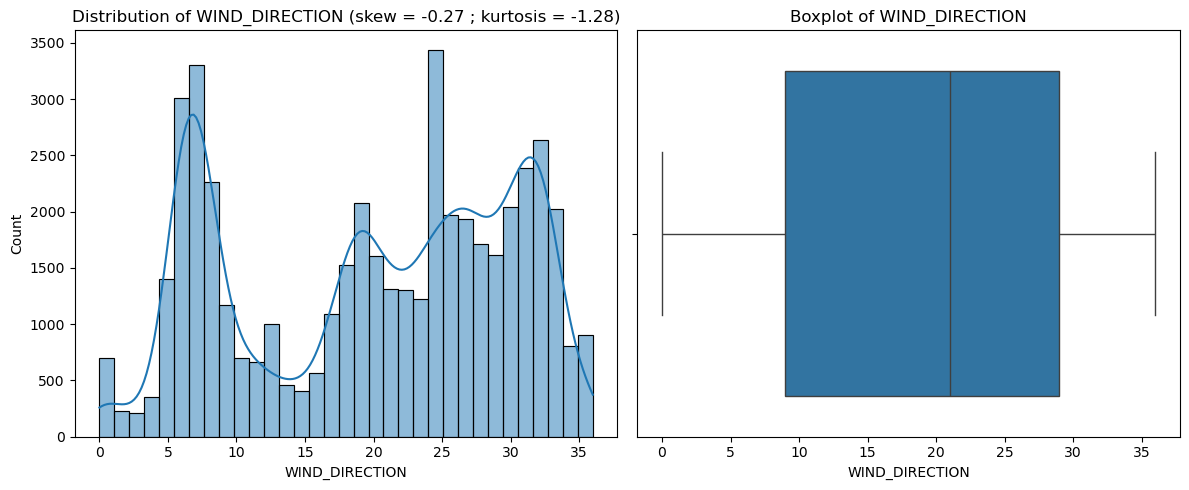

In [50]:
basic_numerical_analysis(eda_df, 'WIND_DIRECTION', missing_data=True)

**Distribution shape** : The distribution is slightly left-skewed (skew = -0.27) but remains ratehr symmetrical. There are two visible modes indicating a bimodal distribution: one around 6\*10° and another around 32\*10°. This indicates that the wind comes mostly from two distinct directions.  

**Peakedness** : Having a negative kurtosis (-1.28), the distribution is platykurtic. The tails are quite light (there seems to be no real tail) and the peaks less sharp than a normal distribution. This also indicates that most values are spread around the two modes and less around the mean.

**Boxplot** : The median stands at 21\*10° while the Q1 and Q3 cover 9\*10° to 29\*10°. The whiskers extend to 0\*10° and 36\*10° showing no outliers.

In summary, the wind direction variable is bimodal, which can be a problem for models that are sensitive to normality. The distribution is flatter than normal and we encounter no outliers. 

Just like temporal variables, this variable has a cyclical nature and should be encoded as such to reveal the cyclical patterns (0\*10° is close to 37\*10°)

Here is what the cyclical encoding's distribution looks like.

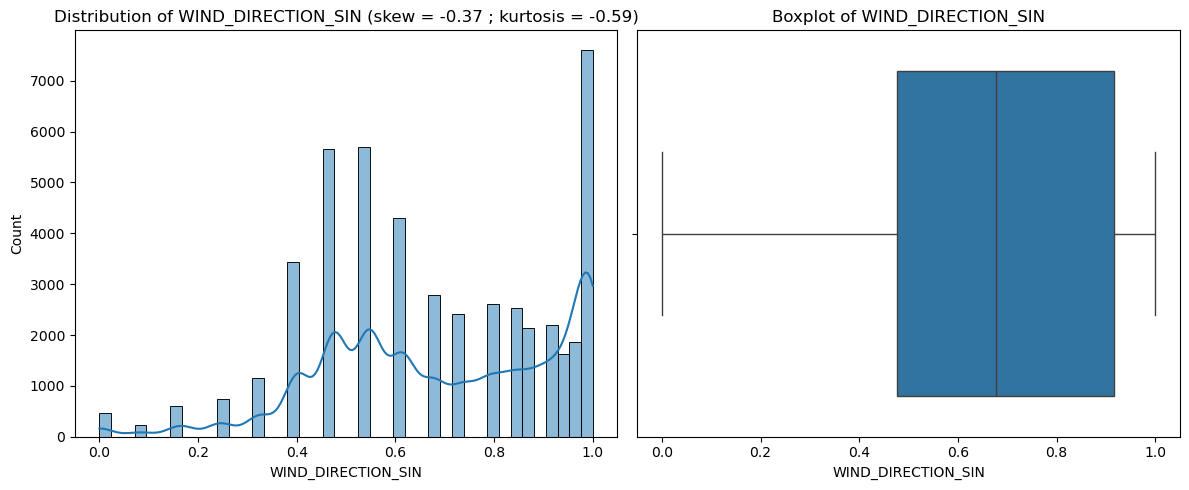

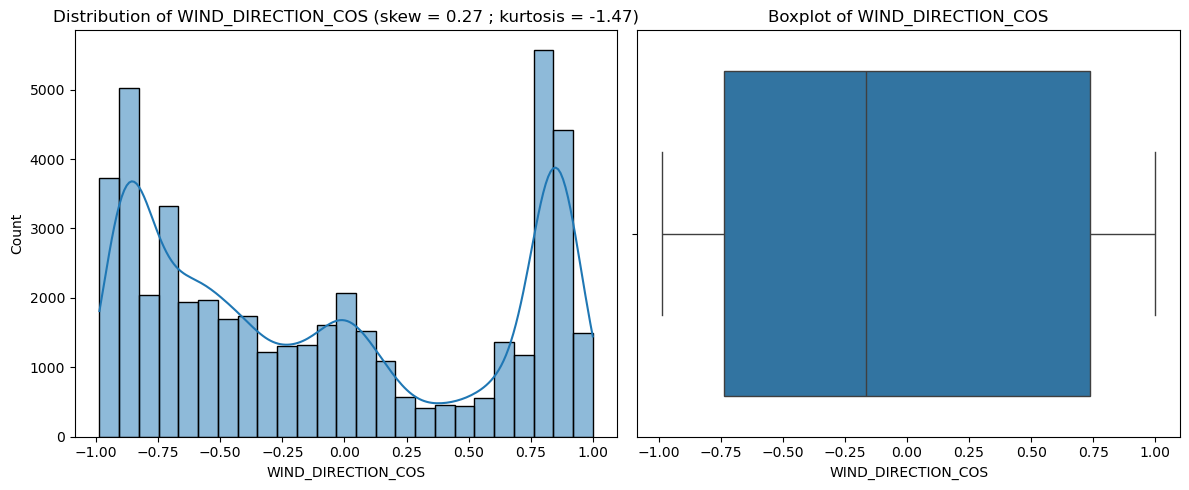

In [51]:
# cyclical transformation for WIND_DIRECTION
# Convert degrees to radians
sin_winddir = np.sin(np.pi * (eda_df['WIND_DIRECTION'].dropna()/38)).tolist()
cos_winddir = np.cos(np.pi * (eda_df['WIND_DIRECTION'].dropna()/38)).tolist()

basic_numerical_analysis(pd.DataFrame(sin_winddir, columns=['WIND_DIRECTION_SIN']), 'WIND_DIRECTION_SIN', show_stats=False)
basic_numerical_analysis(pd.DataFrame(cos_winddir, columns=['WIND_DIRECTION_COS']), 'WIND_DIRECTION_COS', show_stats=False)

#### WIND_SPEED

This feature represents the wind speed in kilometers per hour (km/h) measured at the time of the incident.

Basic statistics :
count    49666.000000
mean        18.328233
std         10.176467
min          0.000000
25%         11.000000
50%         17.000000
75%         24.000000
max         59.000000
Name: WIND_SPEED, dtype: float64

Number of missing values in WIND_SPEED: 3 (0.01%)


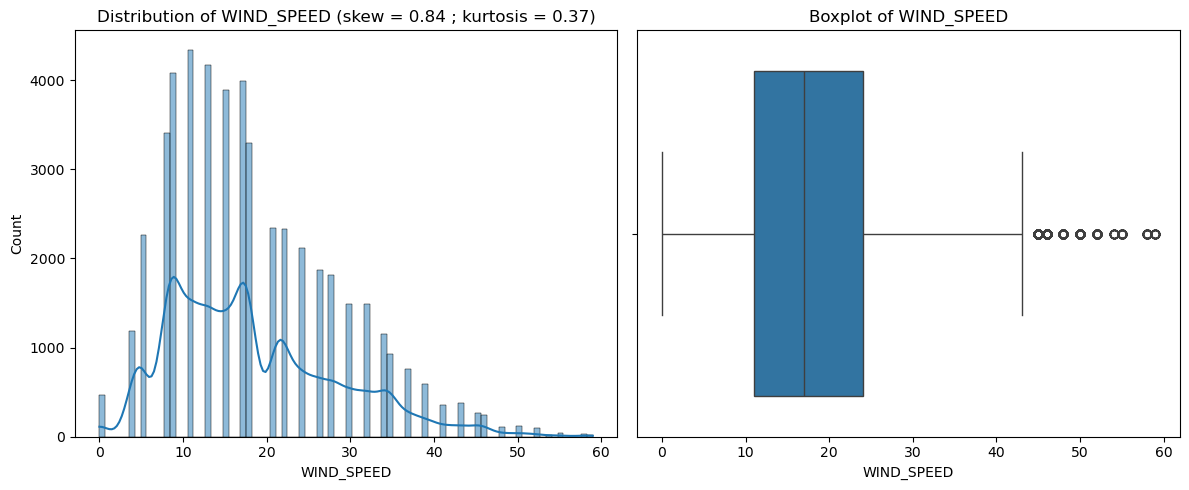

In [52]:
basic_numerical_analysis(eda_df, 'WIND_SPEED', missing_data=True)

The first thing we notice is that the feature seems to be more discrete than continuous. However, we still want to use it as a continuous measure.

**Distribution shape** : The distribution is right-skewed (skew = 0.84) and is quite assymetric. One tail is extenting on the right side towards 45km/h.

**Peakedness** : Having a small positive kurtosis (0.37), the distribution slightly is leptokurtic. The tails are a bit longer and heavy and the peak is more sharp than a normal distribution. This also is an indicator for the presence of possible outliers.

**Boxplot** : The median stands at 17km/h while the Q1 and Q3 cover 11km/h to 24km/h. The whiskers extend to 0km/h and around 45km/h (this is consistent with our tails). The boxplot shows the presence of a few outliers.

In summary, the wind speed variable does not seems relatively normal but could use a transformation to get closer to that goal. 

We can try to apply a yeo-Johnson transformation the skewness.

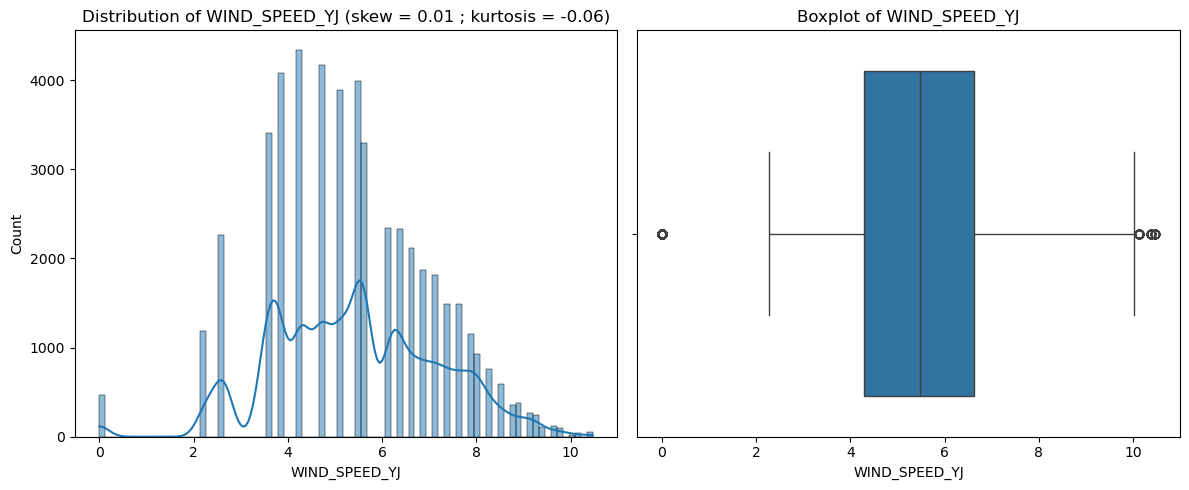

In [53]:
# Yeo-Johnson transformation for WIND_SPEED
yeo_johnson_wind_speed, lambda_param = stats.yeojohnson(eda_df['WIND_SPEED'].dropna())
basic_numerical_analysis(pd.DataFrame(yeo_johnson_wind_speed, columns=['WIND_SPEED_YJ']), 'WIND_SPEED_YJ', show_stats=False)


The Yeo-Johnson transformation did diminish the skewness as well as the kurtosis. This makes our values closer to a normal distribution and more usable  for a regression model.

To end up our eda and training preparation, we verify the dimensions of our dataset. To facilitate possible analysis of the EDA data in other scripts later on, we create a new file named `3_eda_dataset.csv`.

In [54]:
print(f"Final shape of the dataset: {eda_df.shape}")

# Save the cleaned EDA dataset
eda_df.to_csv("../data/3_eda_dataset.csv", index=False)

Final shape of the dataset: (49669, 23)


## Bivariate analysis

In this part, we will analyse the target variable to other significant features.

Keep in mind that the target variable has been transformed with a log1p transformation.

### DELAY / ROUTE

We are interested in knowing if some bus routes have significantly longer delays than others.  

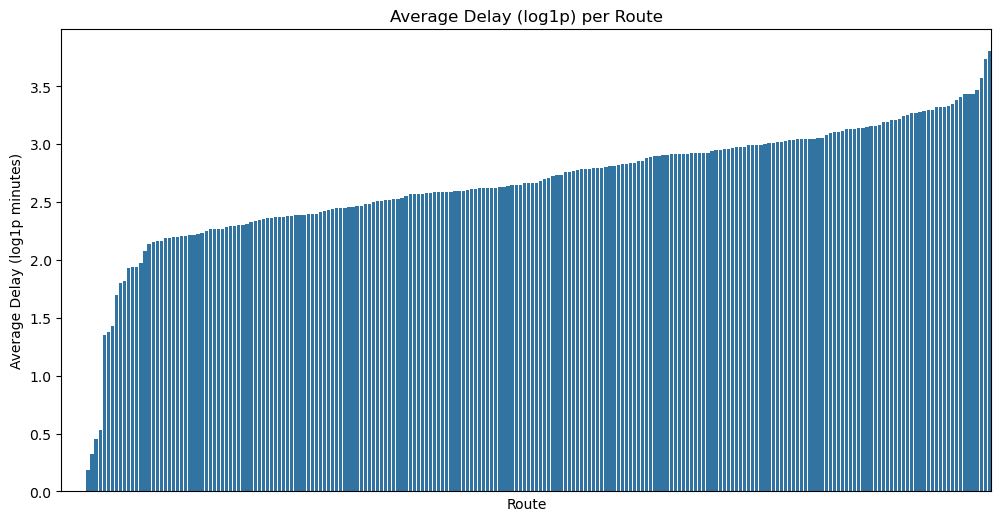

Percentage of routes with average delay (log1p) below 2.0: 8.77%
Percentage of routes with average delay (log1p) above 3.0: 24.56%
Top 5 routes with highest average delay (log1p): ROUTE
462    3.433987
310    3.465736
365    3.573867
341    3.730831
55     3.799881
Name: DELAY_LOG1P, dtype: float64
Top 5 routes with lowest average delay (log1p): ROUTE
500    0.0
505    0.0
899    0.0
555    0.0
701    0.0
Name: DELAY_LOG1P, dtype: float64


In [55]:
# Plot as bar chart
# Calculate average delay per route
avg_delay_per_route = eda_df.groupby('ROUTE')['DELAY_LOG1P'].mean().sort_values()

# Plot as bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_delay_per_route.index, y=avg_delay_per_route.values)
plt.title('Average Delay (log1p) per Route')
plt.xlabel('Route')
plt.ylabel('Average Delay (log1p minutes)')
plt.xticks([])
plt.show()

# Calculate percentages
total_routes = len(avg_delay_per_route)
below_2 = (avg_delay_per_route < 2.0).sum()
above_3 = (avg_delay_per_route > 3.0).sum()
percent_below_2 = (below_2 / total_routes) * 100
percent_above_3 = (above_3 / total_routes) * 100

print(f"Percentage of routes with average delay (log1p) below 2.0: {percent_below_2:.2f}%")
print(f"Percentage of routes with average delay (log1p) above 3.0: {percent_above_3:.2f}%")

# Highest average delay routes
top_5_routes = avg_delay_per_route.tail(5)
print("Top 5 routes with highest average delay (log1p):", top_5_routes)

# Lowest average delay routes
bottom_5_routes = avg_delay_per_route.head(5)
print("Top 5 routes with lowest average delay (log1p):", bottom_5_routes)

We notice that, overall, the average delay per route is in between 2 and 3 log1p minutes. 

Few routes are below this interval (8.77% of routes) and about a quarter (24.56%) of the routes are above this interval.

The highest average delay is around 3.8 log1p minutes (route 55) and the shortest delay is 0 log1p min (multiple routes). 

### DELAY / INCIDENT

We are interested in knowing if some incidents lead to significantly longer delays than others.  

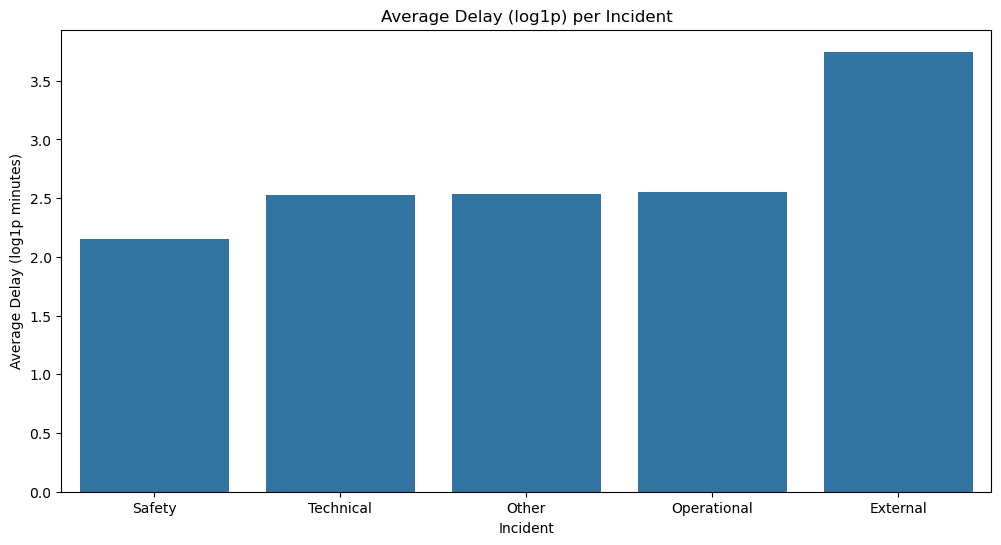

In [56]:
# Plot as bar chart
# Calculate average delay per incident
avg_delay_per_incident = eda_df.groupby('INCIDENT')['DELAY_LOG1P'].mean().sort_values()

# Plot as bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_delay_per_incident.index, y=avg_delay_per_incident.values)
plt.title('Average Delay (log1p) per Incident')
plt.xlabel('Incident')
plt.ylabel('Average Delay (log1p minutes)')
plt.show()

Overall, have incidents the same average delay (log1p). We can notice that `External` incidents generate more delay overall and thah `Safety` incidents cause less delay.

### DELAY / WEATHER_ENG_DESC_LIST

We are interested in knowing if some weather events lead to significantly longer delays than others.  

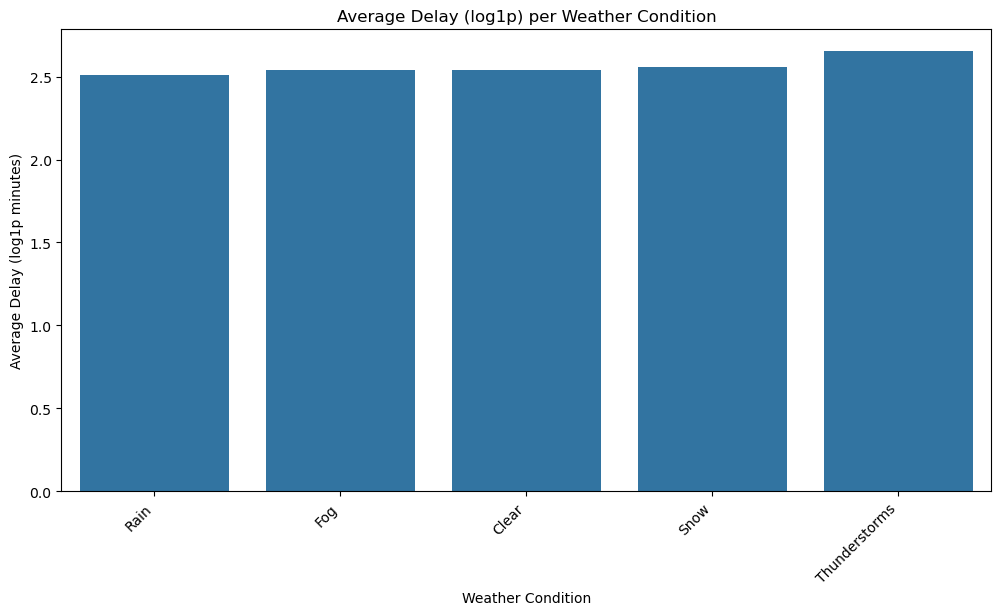

Average delay (log1p) per weather condition:
WEATHER_ENG_DESC_LIST
Rain             2.511473
Fog              2.537609
Clear            2.538490
Snow             2.557503
Thunderstorms    2.651483
Name: DELAY_LOG1P, dtype: float64


In [57]:
# Explode the WEATHER_ENG_DESC_LIST to have one row per weather condition
exploded_weather_df = eda_df.explode('WEATHER_ENG_DESC_LIST')

# Calculate average delay per weather condition
avg_delay_per_weather = exploded_weather_df.groupby('WEATHER_ENG_DESC_LIST')['DELAY_LOG1P'].mean().sort_values()

# Plot as bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_delay_per_weather.index, y=avg_delay_per_weather.values)
plt.title('Average Delay (log1p) per Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Average Delay (log1p minutes)')
plt.xticks(rotation=45, ha='right')
plt.show()

print("Average delay (log1p) per weather condition:")
print(avg_delay_per_weather)

We notice that the different weather conditions don't seem to affect the delay much, all of the weather conditions cause in average 2.5 log1p minutes of delay (thunderstorms cause 2.6 log1p minutes of delay but that is negligible).

### DELAY / WEEK_DAY

We are interested in knowing if some days of the week lead to significantly longer delays than others.  

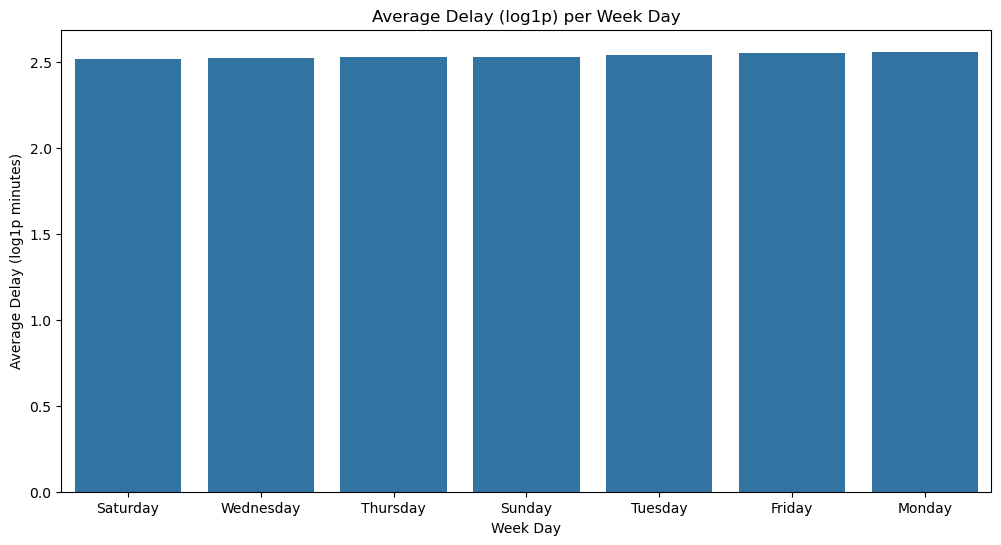

Average delay (log1p) per week day:
WEEK_DAY
Saturday     2.519327
Wednesday    2.523937
Thursday     2.529752
Sunday       2.530171
Tuesday      2.541287
Friday       2.555205
Monday       2.560897
Name: DELAY_LOG1P, dtype: float64


In [58]:
# Plot as bar chart
# Calculate average delay per week_day
avg_delay_per_week_day = eda_df.groupby('WEEK_DAY')['DELAY_LOG1P'].mean().sort_values()

# Plot as bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_delay_per_week_day.index, y=avg_delay_per_week_day.values)
plt.title('Average Delay (log1p) per Week Day')
plt.xlabel('Week Day')
plt.ylabel('Average Delay (log1p minutes)')
plt.show()

print("Average delay (log1p) per week day:")
print(avg_delay_per_week_day)

We notice that the different week days don't seem to affect the delay much, all of the week days cause around 2.5 log1p minutes of delay in average.

### DELAY / LOCAL_MONTH

We are interested in knowing if some months of the year lead to significantly longer delays than others.  

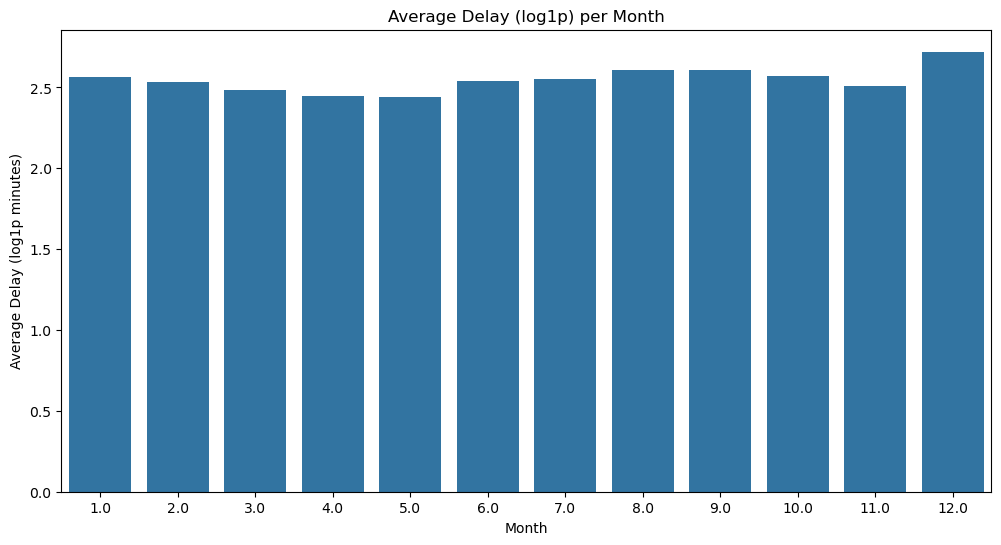

Average delay (log1p) per month:
LOCAL_MONTH
5.0     2.444140
4.0     2.447347
3.0     2.484011
11.0    2.510371
2.0     2.534081
6.0     2.543196
7.0     2.552036
1.0     2.565567
10.0    2.571889
8.0     2.605541
9.0     2.606588
12.0    2.721209
Name: DELAY_LOG1P, dtype: float64


In [59]:
# Plot as bar chart
# Calculate average delay per month
avg_delay_per_month = eda_df.groupby('LOCAL_MONTH')['DELAY_LOG1P'].mean().sort_index()

# Plot as bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_delay_per_month.index, y=avg_delay_per_month.values)
plt.title('Average Delay (log1p) per Month')
plt.xlabel('Month')
plt.ylabel('Average Delay (log1p minutes)')
plt.show()

print("Average delay (log1p) per month:")
print(avg_delay_per_month.sort_values())

We notice that the different months don't seem to affect the delay much, all of the months cause around 2.5 log1p minutes of delay in average. December causes 2.7 log1p linutes of delay on average but let's remember that we only have 2 entrie for this month. 

### DELAY / TEMP

We are interested in knowing if the temperature is correlated to the delay.  

Correlation between TEMP and DELAY_LOG1P: 0.0216


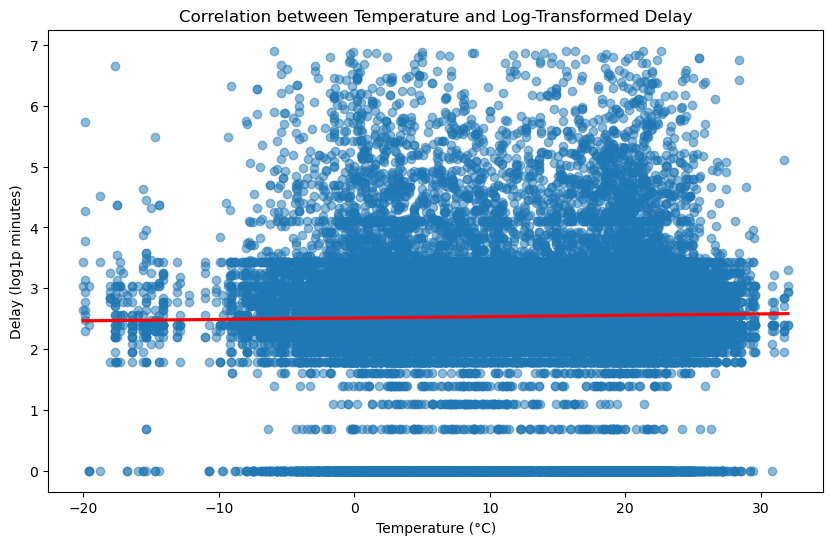

In [60]:
# Calculate correlation
correlation = eda_df['TEMP'].corr(eda_df['DELAY_LOG1P'])
print(f"Correlation between TEMP and DELAY_LOG1P: {correlation:.4f}")

# Scatter plot with regression line to visualize correlation between DELAY_LOG1P and TEMP
plt.figure(figsize=(10, 6))
sns.regplot(x='TEMP', y='DELAY_LOG1P', data=eda_df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Correlation between Temperature and Log-Transformed Delay')
plt.xlabel('Temperature (°C)')
plt.ylabel('Delay (log1p minutes)')
plt.show()

Since the correlation in between the temperature and the log1p delay is weak ($\approx$ 0), we can conclude that there is no linear relationship between temperature and delays.

### DELAY / PRECIPITATIONS

We are interested in knowing if the presence of precipitations affects the delay.

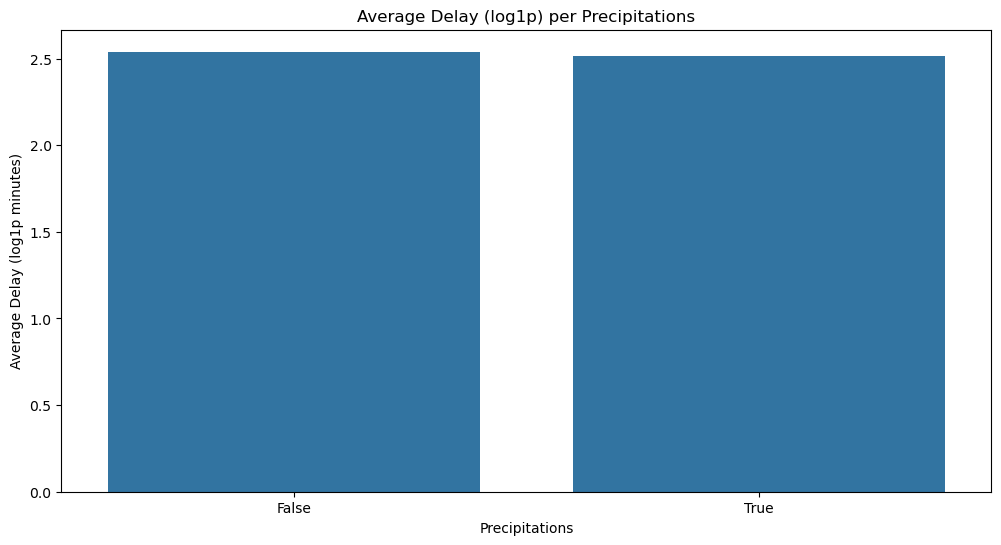

Average delay (log1p) per precipitations:
PRECIPITATIONS
True     2.515030
False    2.539305
Name: DELAY_LOG1P, dtype: float64


In [61]:
# Plot as bar chart
# Calculate average delay per precipitations
avg_delay_per_precipitations = eda_df.groupby('PRECIPITATIONS')['DELAY_LOG1P'].mean().sort_index()

# Plot as bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_delay_per_precipitations.index, y=avg_delay_per_precipitations.values)
plt.title('Average Delay (log1p) per Precipitations')
plt.xlabel('Precipitations')
plt.ylabel('Average Delay (log1p minutes)')
plt.show()

print("Average delay (log1p) per precipitations:")
print(avg_delay_per_precipitations.sort_values())

The presence or not of precipitations does not affect the delay. The average delay remains around 2.5 log1p minutes with and without precipitations.

### DELAY / VISIBILITY

We are interested in knowing if the visibility leads to changes in delays.  

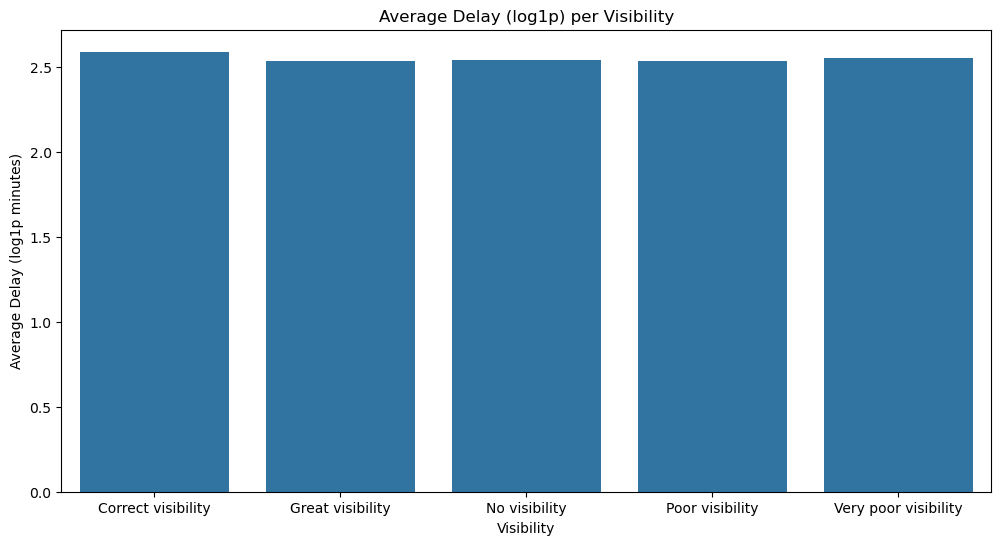

Average delay (log1p) per visibility:
VISIBILITY_DESC
Great visibility        2.534737
Poor visibility         2.537220
No visibility           2.545620
Very poor visibility    2.555884
Correct visibility      2.591477
Name: DELAY_LOG1P, dtype: float64


In [62]:
# Plot as bar chart
# Calculate average delay per visibility
avg_delay_per_visibility = eda_df.groupby('VISIBILITY_DESC')['DELAY_LOG1P'].mean()

# Plot as bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_delay_per_visibility.index, y=avg_delay_per_visibility.values)
plt.title('Average Delay (log1p) per Visibility')
plt.xlabel('Visibility')
plt.ylabel('Average Delay (log1p minutes)')
plt.show()

print("Average delay (log1p) per visibility:")
print(avg_delay_per_visibility.sort_values())

The visibility does not affect the delay, the average delay remains around 2.5 log1p minutes no matter the current visibility.


### DELAY / WIND_SPEED

We are interested in knowing if the wind_speed is correlated to the delay.  

Correlation between WIND_SPEED and DELAY_LOG1P: -0.0151


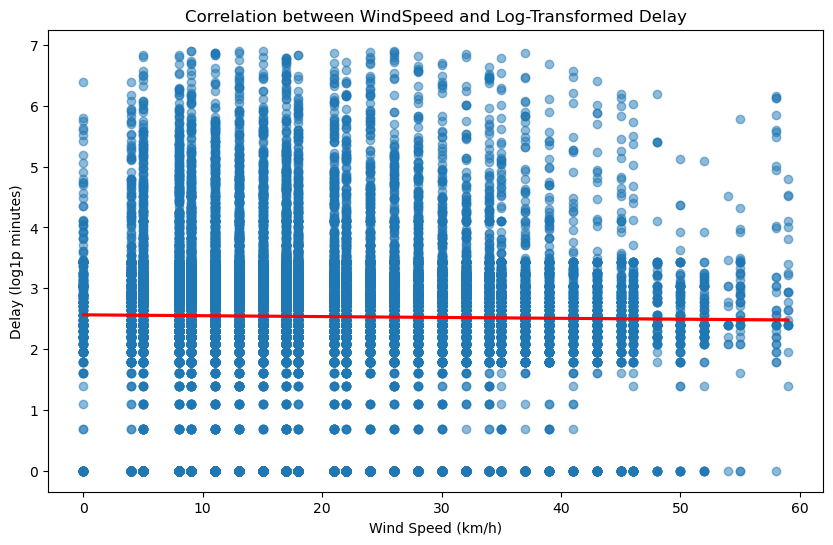

In [63]:
# Calculate correlation
correlation = eda_df['WIND_SPEED'].corr(eda_df['DELAY_LOG1P'])
print(f"Correlation between WIND_SPEED and DELAY_LOG1P: {correlation:.4f}")

# Scatter plot with regression line to visualize correlation between DELAY_LOG1P and WIND_SPEED
plt.figure(figsize=(10, 6))
sns.regplot(x='WIND_SPEED', y='DELAY_LOG1P', data=eda_df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Correlation between WindSpeed and Log-Transformed Delay')
plt.xlabel('Wind Speed (km/h)')
plt.ylabel('Delay (log1p minutes)')
plt.show()

Since the correlation in between the wind speed and the log1p delay is weak ($\approx$ 0), we can conclude that there is no linear relationship between wind speed and delays.

## Conclusions

Through this exercise, we gained guidance as to how we will pre-process our data before training models. 

However, we also saw that the DELAY variable has very few correlations to the rest of the features. This is not promising for the training. But there is still the chance that some underlying relations that we didn't reveal exist and that the models may use to predict the delay correctly.